# Neural Topology Analysis: VISp Response to Natural Movie

## Overview
This notebook explores the topological structure of neural population activity in the Primary Visual Cortex (VISp) of a mouse during the presentation of "Natural Movie One". By applying Topological Data Analysis (TDA) and manifold learning techniques, we aim to uncover high-dimensional geometric features (loops, voids) in the neural state space.

## Workflow

1.  **Data Loading & Filtering**
    *   Load electrophysiology data using `AllenSDK`.
    *   Select units specifically from the **VISp** (Primary Visual Cortex) area.
    *   Extract spike counts aligned with movie frames to create a neural response matrix.

2.  **Feature Extraction**
    *   Compute image metrics for each movie frame: **Brightness** (mean intensity) and **Complexity** (mean gradient magnitude).
    *   These metrics are used to color-code neural trajectories and interpret state transitions.

3.  **Linear Dimensionality Reduction (PCA)**
    *   Reduce high-dimensional neural data to 3 principal components.
    *   Visualize the global trajectory of neural activity in 3D space.

4.  **Topological Data Analysis (TDA)**
    *   **Persistent Homology**: Use `ripser` to calculate Betti numbers (H0, H1, H2, H3).
    *   Quantify topological features:
        *   **H0**: Connected components (Clusters).
        *   **H1**: Loops/Cycles (Repetitive patterns).
        *   **H2/H3**: Voids/Hyper-voids (Forbidden states or complex geometric structures).

5.  **Non-linear Manifold Learning (UMAP)**
    *   Apply UMAP to "unfold" the neural manifold into 2D and 3D latent spaces.
    *   Reveal complex structures (e.g., multiple holes) that may be collapsed in linear PCA projections.

6.  **Interactive Visualization**
    *   Use `Plotly` to create interactive 3D scatter and line plots.
    *   Inspect the relationship between neural topology and visual stimulus features frame-by-frame.

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

In [2]:
output_dir = "../Dataset/RAW"

In [3]:
manifest_path = os.path.join(output_dir, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

print(cache.get_all_session_types())

['brain_observatory_1.1', 'functional_connectivity']


In [4]:
sessions = cache.get_session_table()

sessions.head()

published_at  specimen_id           session_type  \
id                                                                    
715093703  2019-10-03T00:00:00Z    699733581  brain_observatory_1.1   
719161530  2019-10-03T00:00:00Z    703279284  brain_observatory_1.1   
721123822  2019-10-03T00:00:00Z    707296982  brain_observatory_1.1   
732592105  2019-10-03T00:00:00Z    717038288  brain_observatory_1.1   
737581020  2019-10-03T00:00:00Z    718643567  brain_observatory_1.1   

           age_in_days sex                                    full_genotype  \
id                                                                            
715093703        118.0   M    Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt   
719161530        122.0   M    Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt   
721123822        125.0   M  Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt   
732592105        100.0   M                                            wt/wt   
737581020        108.0   M                                            wt/wt   

           unit_count  channel_count  probe_count  \
id                                                  
715093703         884           2219            6   
719161530         755           2214            6   
721123822         444           2229            6   
732592105         824           1847            5   
737581020         568           2218            6   

                                  ecephys_structure_acronyms  
id                                                            
715093703  [CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ...  
719161530  [TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N...  
721123822  [MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ...  
732592105       [grey, VISpm, nan, VISp, VISl, VISal, VISrl]  
737581020      [grey, VISmma, nan, VISpm, VISp, VISl, VISrl]

In [5]:
unique_areas = (
    sessions["ecephys_structure_acronyms"]
        .explode()
        .dropna()
        .unique()
)

unique_areas

array(['CA1', 'VISrl', 'PO', 'LP', 'LGd', 'CA3', 'DG', 'VISl', 'PoT',
       'VISp', 'grey', 'VISpm', 'APN', 'MB', 'VISam', 'TH', 'Eth', 'POL',
       'NOT', 'SUB', 'VL', 'CA2', 'VPM', 'VISal', 'SCig', 'PPT', 'VIS',
       'ProS', 'LGv', 'HPF', 'VISmma', 'PP', 'PIL', 'MGv', 'VPL', 'IGL',
       'SGN', 'IntG', 'LD', 'MGm', 'MGd', 'POST', 'MRN', 'VISli', 'OP',
       'ZI', 'VISmmp', 'PF', 'LT', 'RPF', 'PRE', 'SCiw', 'CP', 'COAa',
       'RT', 'SCop', 'SCsg', 'SCzo', 'COApm', 'OLF', 'BMAa'], dtype=object)

In [6]:
df_unique_areas = pd.DataFrame(unique_areas, columns=['areas'])

VIS_Area = df_unique_areas[df_unique_areas['areas'].str.startswith('VIS')]

VIS_Area

areas
1    VISrl
7     VISl
9     VISp
11   VISpm
14   VISam
23   VISal
26     VIS
30  VISmma
43   VISli
46  VISmmp

In [7]:
VIS_Sessions = sessions[
    (sessions.ecephys_structure_acronyms.apply(lambda x: ('VISam' in x) and ('VISl' in x) and ('VISp' in x) and ('VISal' in x))) 
    & (sessions.session_type.apply(lambda x: 'brain_observatory_1.1' in x))
    & (sessions.probe_count == 6)
]
print(len(VIS_Sessions))
pd_VIS_Sessions = pd.DataFrame(VIS_Sessions.ecephys_structure_acronyms)
pd_VIS_Sessions

12


ecephys_structure_acronyms
id                                                          
719161530  [TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N...
721123822  [MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ...
750332458  [grey, VISrl, nan, VISal, IntG, IGL, LGd, CA3,...
750749662  [LP, DG, CA1, VISp, nan, LGd, CA3, VISrl, VPM,...
754312389  [APN, POL, LP, DG, CA1, VISam, nan, LGd, HPF, ...
755434585  [grey, VISrl, nan, MGv, MGd, TH, LGd, CA3, DG,...
756029989  [TH, DG, CA3, CA1, VISl, nan, PO, Eth, LP, VIS...
757216464  [LP, DG, CA3, CA1, VISrl, nan, PO, LGd, HPF, V...
791319847  [APN, DG, CA1, VISam, nan, LP, TH, VISpm, POL,...
797828357  [PPT, MB, APN, NOT, HPF, ProS, CA1, VISam, nan...
798911424  [APN, TH, Eth, LP, DG, HPF, CA3, CA1, VISrl, n...
799864342  [APN, POL, LP, DG, CA1, VISrl, nan, LGd, CA3, ...

### Step 1: Load Session Data
Load the specific experimental session (ID: 750749662) containing the VISp recordings.

In [8]:
session_id = 750749662
session = cache.get_session_data(session_id)

/opt/anaconda3/envs/TDA/lib/python3.11/site-packages/hdmf/spec/namespace.py:590: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [9]:
session.units.head()

/opt/anaconda3/envs/TDA/lib/python3.11/site-packages/hdmf/spec/namespace.py:590: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
/opt/anaconda3/envs/TDA/lib/python3.11/site-packages/hdmf/spec/namespace.py:590: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
/opt/anaconda3/envs/TDA/lib/python3.11/site-packages

waveform_PT_ratio  waveform_amplitude  amplitude_cutoff  \
unit_id                                                              
951851052           0.562802          172.518840          0.002892   
951851063           0.654514          141.937380          0.001844   
951851101           0.399403          150.047820          0.002267   
951851125           0.513707          209.994135          0.000712   
951851152           0.589894          179.716485          0.054723   

           cluster_id  cumulative_drift   d_prime  firing_rate  \
unit_id                                                          
951851052           4            390.69  5.602064     9.216453   
951851063           5            493.04  5.614530    43.965753   
951851101           9            293.25  6.036566    40.149059   
951851125          12            169.10  5.743368    36.786487   
951851152          15            204.77  4.307685    30.350855   

           isi_violations  isolation_distance   L_ratio  ...  \
unit_id                                                  ...   
951851052        0.111477           69.462814  0.002254  ...   
951851063        0.009307          129.061027  0.001981  ...   
951851101        0.007072          118.832154  0.000019  ...   
951851125        0.023398          117.385050  0.000856  ...   
951851152        0.022162           93.632331  0.008495  ...   

           ecephys_structure_id  ecephys_structure_acronym  \
unit_id                                                      
951851052           560581551.0                        Eth   
951851063                1020.0                         PO   
951851101                1020.0                         PO   
951851125                1020.0                         PO   
951851152           560581551.0                        Eth   

           anterior_posterior_ccf_coordinate  dorsal_ventral_ccf_coordinate  \
unit_id                                                                       
951851052                             7641.0                         3626.0   
951851063                             7638.0                         3617.0   
951851101                             7633.0                         3600.0   
951851125                             7619.0                         3548.0   
951851152                             7616.0                         3539.0   

           left_right_ccf_coordinate  probe_description  \
unit_id                                                   
951851052                     7116.0             probeA   
951851063                     7119.0             probeA   
951851101                     7123.0             probeA   
951851125                     7137.0             probeA   
951851152                     7139.0             probeA   

                          location  probe_sampling_rate  \
unit_id                                                   
951851052  See electrode locations         29999.966623   
951851063  See electrode locations         29999.966623   
951851101  See electrode locations         29999.966623   
951851125  See electrode locations         29999.966623   
951851152  See electrode locations         29999.966623   

           probe_lfp_sampling_rate  probe_has_lfp_data  
unit_id                                                 
951851052              1249.998609                True  
951851063              1249.998609                True  
951851101              1249.998609                True  
951851125              1249.998609                True  
951851152              1249.998609                True  

[5 rows x 40 columns]

In [10]:
session.metadata

/opt/anaconda3/envs/TDA/lib/python3.11/site-packages/hdmf/spec/namespace.py:590: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
/opt/anaconda3/envs/TDA/lib/python3.11/site-packages/hdmf/spec/namespace.py:590: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
/opt/anaconda3/envs/TDA/lib/python3.11/site-packages

{'specimen_name': 'C57BL/6J-412792',
 'session_type': 'brain_observatory_1.1',
 'full_genotype': 'wt/wt',
 'sex': 'M',
 'age_in_days': 92.0,
 'rig_equipment_name': 'NP.1',
 'num_units': 761,
 'num_channels': 2223,
 'num_probes': 6,
 'num_stimulus_presentations': 70390,
 'session_start_time': datetime.datetime(2018, 10, 26, 12, 58, 51, tzinfo=tzoffset(None, -25200)),
 'ecephys_session_id': 750749662,
 'structure_acronyms': ['VISpm',
  nan,
  'PO',
  'LD',
  'LP',
  'DG',
  'CA1',
  'LGd',
  'CA3',
  'VISrl',
  'Eth',
  'VISam',
  'VISp',
  'LGv',
  'IGL',
  'VISl',
  'VISal',
  'VPM',
  'TH',
  'CA2'],
 'stimulus_names': ['spontaneous',
  'gabors',
  'flashes',
  'drifting_gratings',
  'natural_movie_three',
  'natural_movie_one',
  'static_gratings',
  'natural_scenes']}

In [11]:
session.structurewise_unit_counts

LP       142
CA1      113
LGd       82
VISam     64
VISpm     64
VPM       55
VISp      52
VISal     46
VISrl     41
PO        30
DG        26
VISl      20
TH        13
CA3       10
Eth        2
LD         1
Name: ecephys_structure_acronym, dtype: int64

In [12]:
presentations = session.get_stimulus_table("flashes")
units = session.units[session.units["ecephys_structure_acronym"] == 'VISp']

time_step = 0.01
time_bins = np.arange(-0.1, 0.5 + time_step, time_step)

histograms = session.presentationwise_spike_counts(
    stimulus_presentation_ids=presentations.index.values,  
    bin_edges=time_bins,
    unit_ids=units.index.values
)

histograms.coords

Coordinates:
  * stimulus_presentation_id         (stimulus_presentation_id) int64 3647 .....
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 ...
  * unit_id                          (unit_id) int64 951877136 ... 951878911

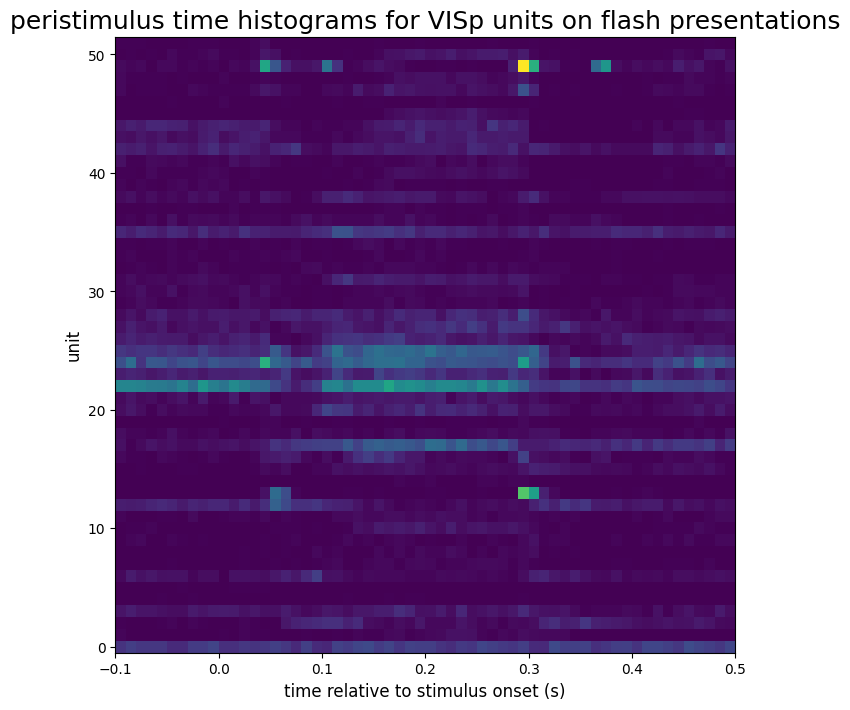

In [13]:
mean_histograms = histograms.mean(dim="stimulus_presentation_id")

fig, ax = plt.subplots(figsize=(8, 8))
ax.pcolormesh(
    mean_histograms["time_relative_to_stimulus_onset"], 
    np.arange(mean_histograms["unit_id"].size),
    mean_histograms.T, 
    vmin=0,
    vmax=1
)

ax.set_ylabel("unit", fontsize=12)
ax.set_xlabel("time relative to stimulus onset (s)", fontsize=12)
ax.set_title("peristimulus time histograms for VISp units on flash presentations", fontsize=18)

plt.show()

In [14]:
session.get_stimulus_table("stimulus_names")

Empty DataFrame
Columns: []
Index: []

Total presentations: 5950


stimulus_block   start_time    stop_time  \
stimulus_presentation_id                                            
51355                               9.0  5909.199079  5909.449290   
51356                               9.0  5909.449290  5909.699500   
51357                               9.0  5909.699500  5909.949711   
51358                               9.0  5909.949711  5910.199922   
51359                               9.0  5910.199922  5910.450124   

                           stimulus_name frame  duration  \
stimulus_presentation_id                                   
51355                     natural_scenes  60.0  0.250211   
51356                     natural_scenes  55.0  0.250211   
51357                     natural_scenes  91.0  0.250211   
51358                     natural_scenes  58.0  0.250211   
51359                     natural_scenes  62.0  0.250202   

                          stimulus_condition_id  
stimulus_presentation_id                         
51355                                      4908  
51356                                      4909  
51357                                      4910  
51358                                      4911  
51359                                      4912

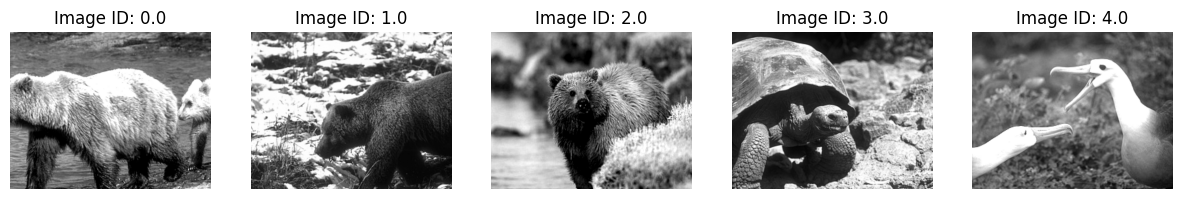

In [15]:
natural_scenes_table = session.get_stimulus_table("natural_scenes")
print(f"Total presentations: {len(natural_scenes_table)}")
display(natural_scenes_table.head())

unique_images = np.sort(natural_scenes_table['frame'].unique())
unique_images = unique_images[unique_images != -1] 

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, img_id in enumerate(unique_images[:5]):
    img = cache.get_natural_scene_template(img_id)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Image ID: {img_id}")
    axes[i].axis('off')
plt.show()

In [16]:
stimulus_names = session.stimulus_names
print(stimulus_names)

['spontaneous', 'gabors', 'flashes', 'drifting_gratings', 'natural_movie_three', 'natural_movie_one', 'static_gratings', 'natural_scenes']



>>> Stimulus: spontaneous (Parametric/Spontaneous - No static template to show)

>>> Stimulus: gabors (Parametric/Spontaneous - No static template to show)

>>> Stimulus: flashes (Parametric/Spontaneous - No static template to show)

>>> Stimulus: drifting_gratings (Parametric/Spontaneous - No static template to show)

>>> Stimulus: natural_movie_three


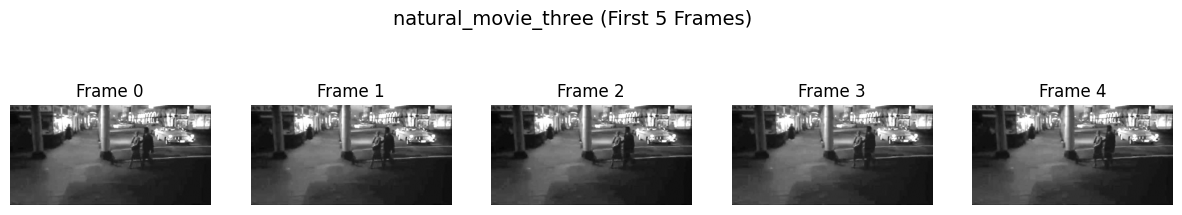


>>> Stimulus: natural_movie_one


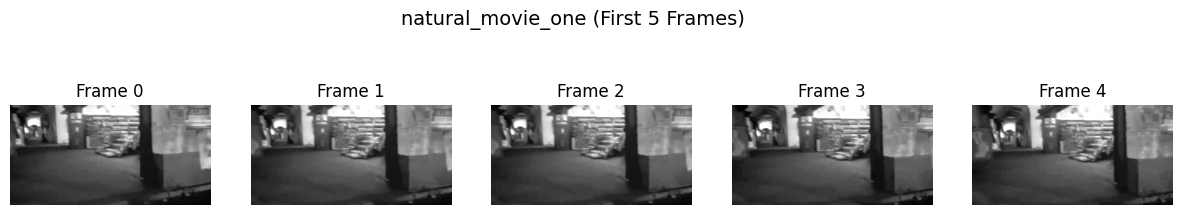


>>> Stimulus: static_gratings (Parametric/Spontaneous - No static template to show)

>>> Stimulus: natural_scenes


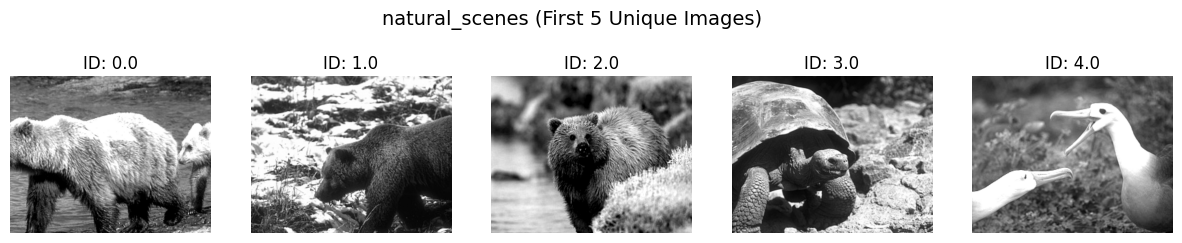

In [17]:
for stim_name in session.stimulus_names:
    
    if stim_name == 'natural_scenes':
        print(f"\n>>> Stimulus: {stim_name}")
        table = session.get_stimulus_table(stim_name)
        unique_images = np.sort(table['frame'].unique())
        unique_images = unique_images[unique_images != -1]
        
        fig, axes = plt.subplots(1, 5, figsize=(15, 3))
        fig.suptitle(f"{stim_name} (First 5 Unique Images)", fontsize=14)
        for i, img_id in enumerate(unique_images[:5]):
            img = cache.get_natural_scene_template(img_id)
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f"ID: {img_id}")
            axes[i].axis('off')
        plt.show()

    elif 'natural_movie' in stim_name:
        print(f"\n>>> Stimulus: {stim_name}")
        movie_number = 1 if 'one' in stim_name else 3
        try:
            movie_template = cache.get_natural_movie_template(movie_number)
            
            fig, axes = plt.subplots(1, 5, figsize=(15, 3))
            fig.suptitle(f"{stim_name} (First 5 Frames)", fontsize=14)
            for i in range(5):
                axes[i].imshow(movie_template[i, :, :], cmap='gray')
                axes[i].set_title(f"Frame {i}")
                axes[i].axis('off')
            plt.show()
        except Exception as e:
            print(f"Could not load template for {stim_name}: {e}")

    else:
        print(f"\n>>> Stimulus: {stim_name} (Parametric/Spontaneous - No static template to show)")

In [18]:
movie_one_template = cache.get_natural_movie_template(1)
print(f"Natural Movie One Total Frames: {movie_one_template.shape[0]}")
print(f"Movie Dimensions: {movie_one_template.shape[1]} x {movie_one_template.shape[2]}")

Natural Movie One Total Frames: 900
Movie Dimensions: 304 x 608


In [19]:
import h5py

nwb_path = Path(output_dir) / f"session_{session_id}" / f"session_{session_id}.nwb"

print(f"Loading HDF5 file from: {nwb_path}")

if nwb_path.exists():
    with h5py.File(nwb_path, 'r') as f:
        print("\n--- Root Keys (Top-level groups) ---")
        print(list(f.keys()))
        
        if 'processing' in f:
            print("\n--- Inside 'processing' group ---")
            print(list(f['processing'].keys()))
            
        try:
            dset = f['intervals']['natural_movie_one_presentations']['id']
            print(f"\n--- Dataset 'natural_movie_one_presentations/id' ---")
            print(f"Shape: {dset.shape}")
            print(f"Dtype: {dset.dtype}")
            print(f"First 5 values: {dset[:5]}")
        except KeyError:
            print("\nTarget dataset not found in this file structure.")
else:
    print(f"File not found at {nwb_path}. Please ensure the session data is downloaded.")

Loading HDF5 file from: ../Dataset/RAW/session_750749662/session_750749662.nwb

--- Root Keys (Top-level groups) ---
['acquisition', 'analysis', 'file_create_date', 'general', 'identifier', 'intervals', 'processing', 'session_description', 'session_start_time', 'specifications', 'stimulus', 'timestamps_reference_time', 'units']

--- Inside 'processing' group ---
['eye_tracking', 'eye_tracking_rig_metadata', 'filtered_gaze_mapping', 'optotagging', 'raw_gaze_mapping', 'running', 'stimulus']

--- Dataset 'natural_movie_one_presentations/id' ---
Shape: (18000,)
Dtype: int64
First 5 values: [0 1 2 3 4]


In [20]:
movie_one_table = session.get_stimulus_table("natural_movie_one")
frame_duration = movie_one_table['duration'].mean()
frame_rate = 1 / frame_duration

print(f"Average Frame Duration: {frame_duration:.4f} seconds")
print(f"Stimulus Frame Rate: {frame_rate:.2f} Hz")

print("\n--- Probe Sampling Rates ---")
display(session.probes[['description', 'sampling_rate']])

Average Frame Duration: 0.0334 seconds
Stimulus Frame Rate: 29.97 Hz

--- Probe Sampling Rates ---


description  sampling_rate
id                                  
769322802      probeA   29999.966623
769322804      probeB   29999.914735
769322806      probeC   29999.993938
769322808      probeD   29999.919305
769322810      probeE   29999.996070
769322812      probeF   30000.037601

In [21]:
movie_one_table = session.get_stimulus_table("natural_movie_one")
start_time = movie_one_table.iloc[0]['start_time']
end_time = movie_one_table.iloc[0]['stop_time']

print(f"Frame 0 Start Time: {start_time}")
print(f"Frame 0 Stop Time: {end_time}")

visp_units = session.units[session.units["ecephys_structure_acronym"] == "VISp"]
print(f"Number of VISp units: {len(visp_units)}")

spike_times = session.spike_times

print("\n--- Raw Spike Times for First 5 VISp Units (during Frame 0) ---")
for unit_id in visp_units.index[:5]:
    all_spikes = spike_times[unit_id]
    frame_spikes = all_spikes[(all_spikes >= start_time) & (all_spikes <= end_time)]
    
    print(f"Unit {unit_id}: {len(frame_spikes)} spikes found at {frame_spikes}")

Frame 0 Start Time: 2846.623388924872
Frame 0 Stop Time: 2846.6567503604865
Number of VISp units: 52

--- Raw Spike Times for First 5 VISp Units (during Frame 0) ---
Unit 951877136: 1 spikes found at [2846.63578029]
Unit 951877196: 0 spikes found at []
Unit 951877272: 0 spikes found at []
Unit 951877260: 0 spikes found at []
Unit 951877312: 0 spikes found at []


Target Probe ID (containing VISp): 769322806
Loading LFP data... (this might take a while)

--- LFP Data Summary ---
<xarray.DataArray 'LFP' (time: 12367270, channel: 88)>
array([[ 4.5044999e-05,  3.7829999e-05,  4.8944999e-05, ...,
         0.0000000e+00,  0.0000000e+00,  4.8749998e-06],
       [-4.0949999e-06, -2.8275001e-05,  1.5600001e-05, ...,
        -3.1200000e-06, -9.3600001e-06,  1.0140000e-05],
       [ 2.7689999e-05,  2.3400000e-06,  3.1200001e-05, ...,
         1.3650000e-06, -2.5350000e-06, -6.8250001e-06],
       ...,
       [-7.5270000e-05, -3.9194998e-05, -3.9974999e-05, ...,
         1.6770000e-05,  4.7580001e-05, -1.7549999e-05],
       [-5.9865000e-05, -3.5685000e-05, -5.8500000e-06, ...,
         8.3850000e-06,  2.9639999e-05, -1.7160000e-05],
       [-5.5770000e-05, -2.9249999e-05, -7.4099999e-06, ...,
         1.1700000e-06,  2.1255000e-05, -4.8749998e-06]], dtype=float32)
Coordinates:
  * time     (time) float64 3.718 3.719 3.719 ... 9.898e+03 9.898e+03 9.898e+03

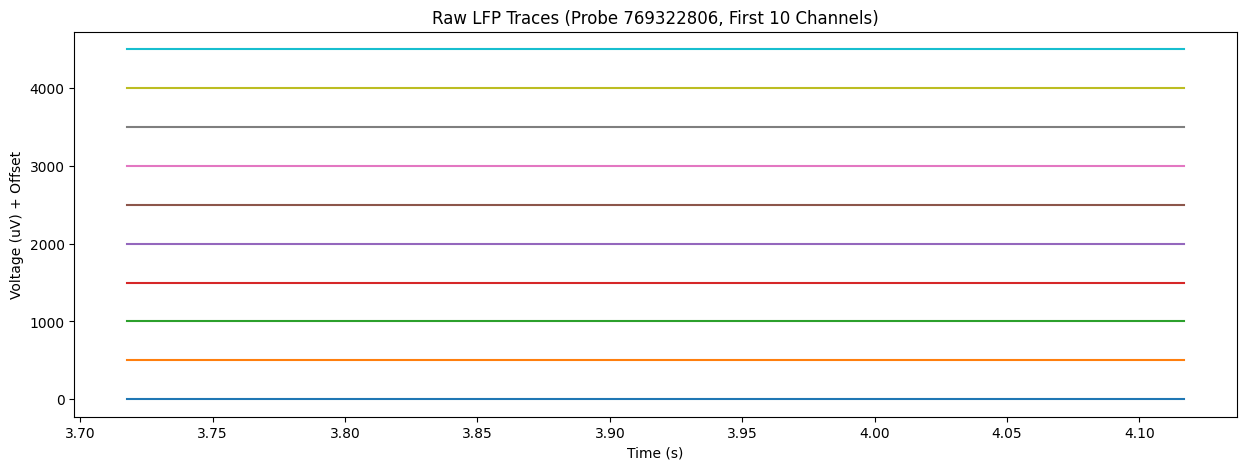

In [22]:
visp_probes = session.units[session.units["ecephys_structure_acronym"] == "VISp"]["probe_id"].unique()
target_probe_id = visp_probes[0]
print(f"Target Probe ID (containing VISp): {target_probe_id}")

try:
    print("Loading LFP data... (this might take a while)")
    lfp = session.get_lfp(target_probe_id)
    
    print("\n--- LFP Data Summary ---")
    print(lfp)
    
    start_idx = 0
    end_idx = 500
    
    fig, ax = plt.subplots(figsize=(15, 5))
    for i in range(10):
        ax.plot(lfp.time[start_idx:end_idx], lfp.data[start_idx:end_idx, i] + i*500, label=f"Ch {i}")
    
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Voltage (uV) + Offset")
    ax.set_title(f"Raw LFP Traces (Probe {target_probe_id}, First 10 Channels)")
    plt.show()

except Exception as e:
    print(f"\nCould not load LFP data: {e}")
    print("LFP data might not be downloaded. Check your manifest or download settings.")

### Step 2: Construct Neural Response Matrix
Align spike times with the "Natural Movie One" frames to create a (Frames x Neurons) response matrix.

Selected 52 units from VISp
Total Presentations (Frames x Repeats): 18000
Time Window per Frame: 0.0334 s
Calculating spike counts... (this may take a moment)

--- Final Response Matrix Created ---
Shape: (900, 52) (Frames x Neurons)

--- Final Response Matrix Created ---
Shape: (900, 52) (Frames x Neurons)


unit_id  951877136  951877196  951877272  951877260  951877312  951877352  \
frame                                                                       
0.0           0.50       0.05       0.45       0.45       0.00       0.00   
1.0           0.50       0.00       0.50       0.40       0.05       0.05   
2.0           0.55       0.00       0.15       0.05       0.15       0.05   
3.0           0.40       0.00       0.15       1.85       0.20       0.00   
4.0           0.30       0.05       0.40       1.75       0.00       0.00   

unit_id  951877405  951877391  951877505  951877602  ...  951878485  \
frame                                                ...              
0.0           0.20       0.10       0.05       0.05  ...       0.20   
1.0           0.35       0.00       0.00       0.15  ...       0.25   
2.0           0.15       0.10       0.00       0.00  ...       0.15   
3.0           0.15       0.20       0.00       0.10  ...       0.25   
4.0           0.10       0.25       0.00       0.15  ...       0.45   

unit_id  951878472  951878379  951878626  951878648  951878743  951878821  \
frame                                                                       
0.0           0.15       0.45       0.00       0.25       0.95       0.70   
1.0           0.25       0.00       0.00       0.20       0.40       0.30   
2.0           0.15       0.35       0.20       0.05       0.50       0.50   
3.0           0.20       0.40       0.50       0.90       1.15       1.05   
4.0           0.40       0.60       0.25       1.05       0.55       0.80   

unit_id  951878811  951878800  951878911  
frame                                     
0.0           0.60       1.15       0.20  
1.0           0.00       0.65       0.15  
2.0           0.00       1.00       0.00  
3.0           0.10       1.35       0.10  
4.0           0.05       1.55       0.05  

[5 rows x 52 columns]

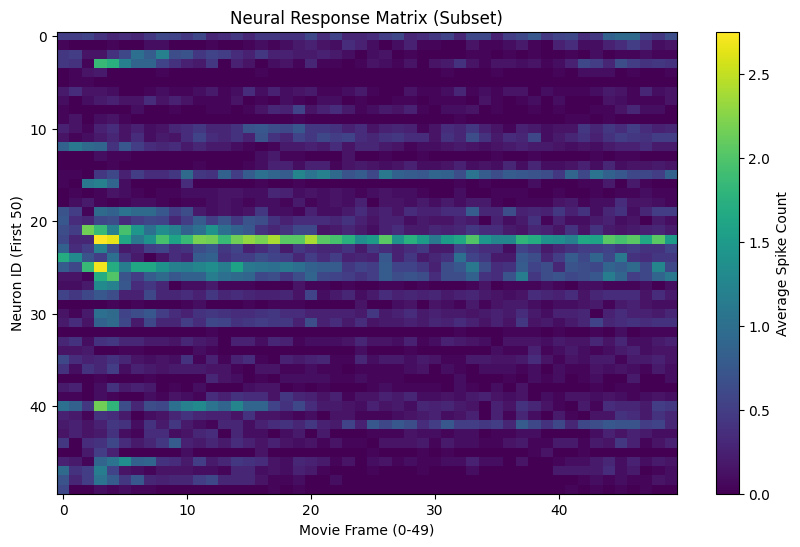

In [23]:
visp_units = session.units[session.units["ecephys_structure_acronym"] == "VISp"]
print(f"Selected {len(visp_units)} units from VISp")

movie_table = session.get_stimulus_table("natural_movie_one")
print(f"Total Presentations (Frames x Repeats): {len(movie_table)}")

frame_duration = movie_table['duration'].mean()
print(f"Time Window per Frame: {frame_duration:.4f} s")

print("Calculating spike counts... (this may take a moment)")
spike_counts_xr = session.presentationwise_spike_counts(
    stimulus_presentation_ids=movie_table.index.values,
    bin_edges=np.array([0, frame_duration]),
    unit_ids=visp_units.index.values
)

response_matrix_all = spike_counts_xr.sum(dim="time_relative_to_stimulus_onset")

df_response = pd.DataFrame(
    response_matrix_all.values,
    index=movie_table.index,
    columns=visp_units.index
)
df_response['frame'] = movie_table['frame']

average_response_matrix = df_response.groupby('frame').mean()

print("\n--- Final Response Matrix Created ---")
print(f"Shape: {average_response_matrix.shape} (Frames x Neurons)")
display(average_response_matrix.head())

plt.figure(figsize=(10, 6))
plt.imshow(average_response_matrix.iloc[:50, :50].T, aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel("Movie Frame (0-49)")
plt.ylabel("Neuron ID (First 50)")
plt.title("Neural Response Matrix (Subset)")
plt.colorbar(label="Average Spike Count")
plt.show()

--- Depth Sorting ---
Shallowest Unit: 2920 um
Deepest Unit: 2240 um


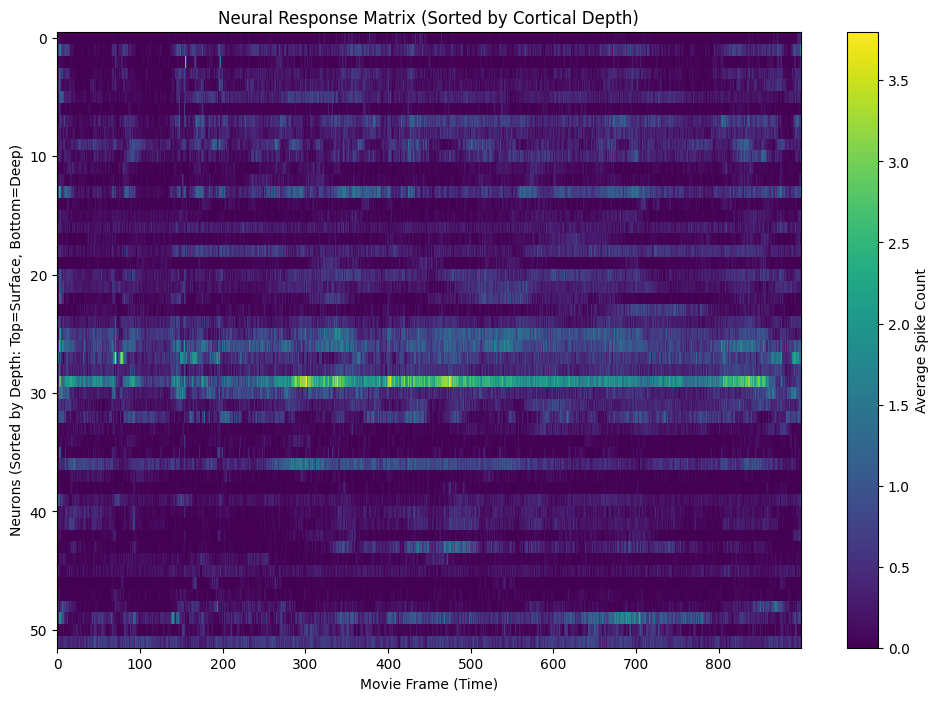

In [24]:
depths = visp_units['probe_vertical_position']

sorted_units = visp_units.sort_values(by="probe_vertical_position", ascending=False)

print("--- Depth Sorting ---")
print(f"Shallowest Unit: {sorted_units.iloc[0]['probe_vertical_position']} um")
print(f"Deepest Unit: {sorted_units.iloc[-1]['probe_vertical_position']} um")

sorted_response_matrix = average_response_matrix[sorted_units.index]

plt.figure(figsize=(12, 8))
plt.imshow(sorted_response_matrix.T, aspect='auto', cmap='viridis', interpolation='none')

plt.xlabel("Movie Frame (Time)")
plt.ylabel("Neurons (Sorted by Depth: Top=Surface, Bottom=Deep)")
plt.title("Neural Response Matrix (Sorted by Cortical Depth)")
plt.colorbar(label="Average Spike Count")
plt.show()

In [25]:
total_channels = len(session.channels)
print(f"Total Channels in Session: {total_channels}")

target_probe_channels = session.channels[session.channels['probe_id'] == target_probe_id]
print(f"Channels in Target Probe ({target_probe_id}): {len(target_probe_channels)}")

print("\n--- Channel Counts per Probe ---")
print(session.channels.groupby('probe_id').size())

display(target_probe_channels[['probe_vertical_position', 'ecephys_structure_acronym']].head())

Total Channels in Session: 2223
Channels in Target Probe (769322806): 373

--- Channel Counts per Probe ---
probe_id
769322802    373
769322804    369
769322806    373
769322808    367
769322810    370
769322812    371
dtype: int64


probe_vertical_position ecephys_structure_acronym
id                                                          
850163848                      260                        LP
850163850                      280                        LP
850163852                      280                        LP
850163854                      300                        LP
850163856                      300                        LP

Total Units in Session: 761
Calculating spike counts for ALL units... (this will take longer)


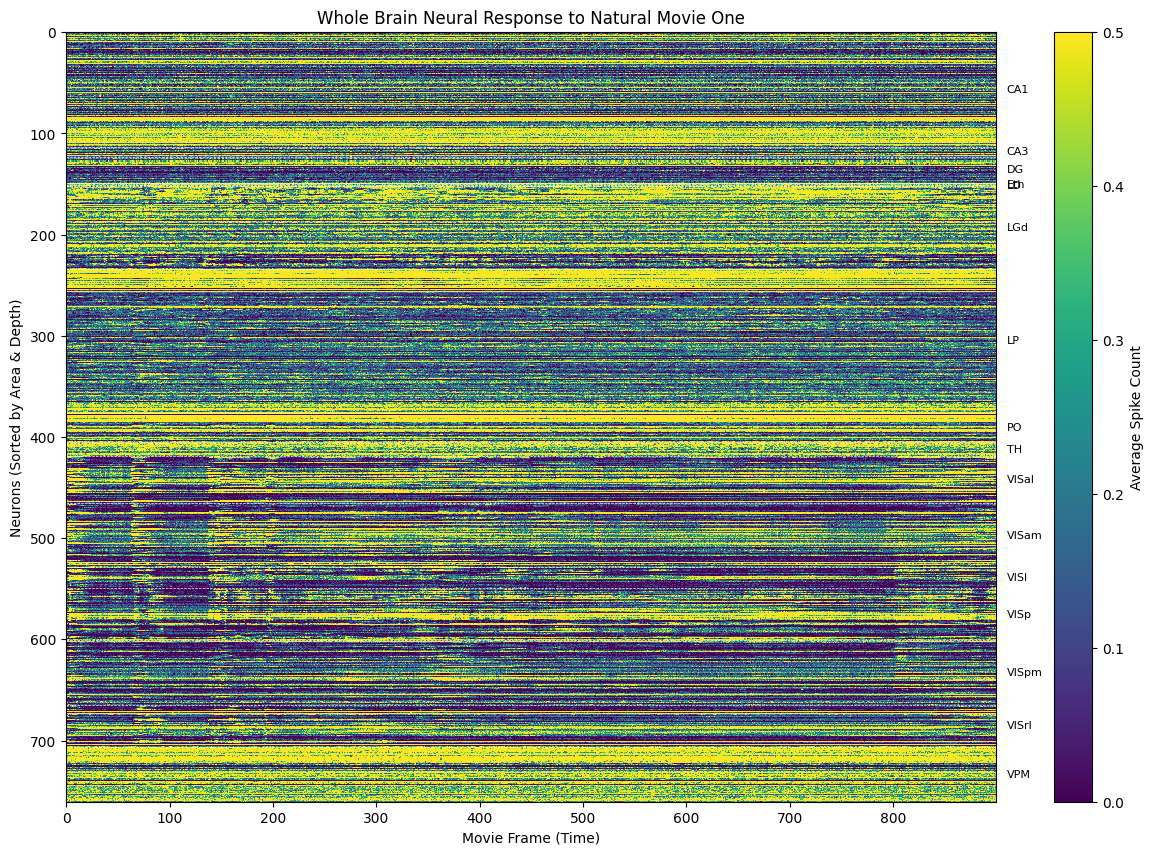

In [26]:
all_units = session.units
print(f"Total Units in Session: {len(all_units)}")

print("Calculating spike counts for ALL units... (this will take longer)")
spike_counts_all_xr = session.presentationwise_spike_counts(
    stimulus_presentation_ids=movie_table.index.values,
    bin_edges=np.array([0, frame_duration]),
    unit_ids=all_units.index.values
)

response_matrix_total = spike_counts_all_xr.sum(dim="time_relative_to_stimulus_onset")

df_response_total = pd.DataFrame(
    response_matrix_total.values,
    index=movie_table.index,
    columns=all_units.index
)
df_response_total['frame'] = movie_table['frame']

average_response_matrix_total = df_response_total.groupby('frame').mean()

sorted_all_units = all_units.sort_values(
    by=["ecephys_structure_acronym", "probe_vertical_position"], 
    ascending=[True, False]
)

sorted_response_matrix_total = average_response_matrix_total[sorted_all_units.index]

plt.figure(figsize=(15, 10))
plt.imshow(sorted_response_matrix_total.T, aspect='auto', cmap='viridis', interpolation='none', vmin=0, vmax=0.5) 

plt.xlabel("Movie Frame (Time)")
plt.ylabel("Neurons (Sorted by Area & Depth)")
plt.title("Whole Brain Neural Response to Natural Movie One")
plt.colorbar(label="Average Spike Count")

area_counts = sorted_all_units['ecephys_structure_acronym'].value_counts(sort=False)
area_labels = []
current_idx = 0
for area, group in sorted_all_units.groupby("ecephys_structure_acronym", sort=True):
    count = len(group)
    plt.axhline(y=current_idx, color='white', linestyle='--', linewidth=0.5)
    plt.text(910, current_idx + count/2, area, verticalalignment='center', fontsize=8)
    current_idx += count

plt.show()

--- Session Probes Metadata ---


description                 location  sampling_rate  \
id                                                              
769322802      probeA  See electrode locations   29999.966623   
769322804      probeB  See electrode locations   29999.914735   
769322806      probeC  See electrode locations   29999.993938   
769322808      probeD  See electrode locations   29999.919305   
769322810      probeE  See electrode locations   29999.996070   
769322812      probeF  See electrode locations   30000.037601   

           lfp_sampling_rate  has_lfp_data  
id                                          
769322802        1249.998609          True  
769322804        1249.996447          True  
769322806        1249.999747          True  
769322808        1249.996638          True  
769322810        1249.999836          True  
769322812        1250.001567          True

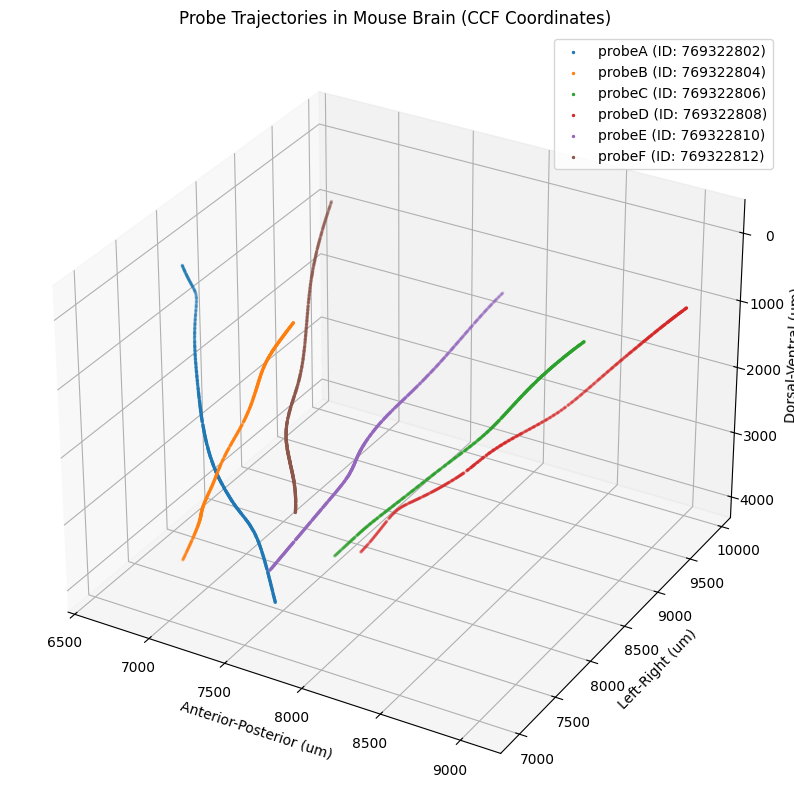

In [27]:
print("--- Session Probes Metadata ---")
display(session.probes)

if 'anterior_posterior_ccf_coordinate' in session.channels.columns:
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    for probe_id, probe_info in session.probes.iterrows():
        probe_channels = session.channels[session.channels['probe_id'] == probe_id]
        
        valid_channels = probe_channels.dropna(subset=['anterior_posterior_ccf_coordinate', 'dorsal_ventral_ccf_coordinate', 'left_right_ccf_coordinate'])
        
        if not valid_channels.empty:
            x = valid_channels['anterior_posterior_ccf_coordinate']
            y = valid_channels['left_right_ccf_coordinate']
            z = valid_channels['dorsal_ventral_ccf_coordinate']
            
            ax.scatter(x, y, z, label=f"{probe_info['description']} (ID: {probe_id})", s=2)

    ax.set_xlabel('Anterior-Posterior (um)')
    ax.set_ylabel('Left-Right (um)')
    ax.set_zlabel('Dorsal-Ventral (um)')
    
    ax.invert_zaxis() 
    
    ax.set_title('Probe Trajectories in Mouse Brain (CCF Coordinates)')
    ax.legend()
    plt.show()
else:
    print("CCF coordinates are not available for this session.")

In [28]:
print("=== session.probes Table Structure ===")
print(session.probes.info())
display(session.probes.head())

print("\n=== session.channels Table Structure ===")
print(session.channels.info())
display(session.channels.head())

probe_a_id = session.probes.index[0]
print(f"\n=== Example Data for Probe {probe_a_id} (First 10 Channels) ===")
cols_of_interest = [
    'probe_vertical_position', 
    'anterior_posterior_ccf_coordinate', 
    'dorsal_ventral_ccf_coordinate', 
    'left_right_ccf_coordinate',
    'ecephys_structure_acronym'
]
display(session.channels[session.channels['probe_id'] == probe_a_id][cols_of_interest].head(10))

=== session.probes Table Structure ===
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 769322802 to 769322812
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   description        6 non-null      object 
 1   location           6 non-null      object 
 2   sampling_rate      6 non-null      float64
 3   lfp_sampling_rate  6 non-null      float64
 4   has_lfp_data       6 non-null      bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 418.0+ bytes
None


description                 location  sampling_rate  \
id                                                              
769322802      probeA  See electrode locations   29999.966623   
769322804      probeB  See electrode locations   29999.914735   
769322806      probeC  See electrode locations   29999.993938   
769322808      probeD  See electrode locations   29999.919305   
769322810      probeE  See electrode locations   29999.996070   

           lfp_sampling_rate  has_lfp_data  
id                                          
769322802        1249.998609          True  
769322804        1249.996447          True  
769322806        1249.999747          True  
769322808        1249.996638          True  
769322810        1249.999836          True


=== session.channels Table Structure ===
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2223 entries, 850169748 to 850167196
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   filtering                          2223 non-null   object 
 1   probe_channel_number               2223 non-null   int64  
 2   probe_horizontal_position          2223 non-null   int64  
 3   probe_id                           2223 non-null   int64  
 4   probe_vertical_position            2223 non-null   int64  
 5   structure_acronym                  1910 non-null   object 
 6   ecephys_structure_id               1910 non-null   float64
 7   ecephys_structure_acronym          1910 non-null   object 
 8   anterior_posterior_ccf_coordinate  2223 non-null   float64
 9   dorsal_ventral_ccf_coordinate      2223 non-null   float64
 10  left_right_ccf_coordinate          2223 non-null   float64
dtypes

filtering  \
id                                                             
850169748  AP band: 500 Hz high-pass; LFP band: 1000 Hz l...   
850169752  AP band: 500 Hz high-pass; LFP band: 1000 Hz l...   
850169756  AP band: 500 Hz high-pass; LFP band: 1000 Hz l...   
850169758  AP band: 500 Hz high-pass; LFP band: 1000 Hz l...   
850169762  AP band: 500 Hz high-pass; LFP band: 1000 Hz l...   

           probe_channel_number  probe_horizontal_position   probe_id  \
id                                                                      
850169748                   322                         59  769322804   
850169752                   324                         43  769322804   
850169756                   326                         59  769322804   
850169758                   327                         27  769322804   
850169762                   329                         11  769322804   

           probe_vertical_position structure_acronym  ecephys_structure_id  \
id                                                                           
850169748                     3240             VISpm                 533.0   
850169752                     3260             VISpm                 533.0   
850169756                     3280             VISpm                 533.0   
850169758                     3280             VISpm                 533.0   
850169762                     3300             VISpm                 533.0   

          ecephys_structure_acronym  anterior_posterior_ccf_coordinate  \
id                                                                       
850169748                     VISpm                             7532.0   
850169752                     VISpm                             7536.0   
850169756                     VISpm                             7541.0   
850169758                     VISpm                             7543.0   
850169762                     VISpm                             7549.0   

           dorsal_ventral_ccf_coordinate  left_right_ccf_coordinate  
id                                                                   
850169748                          361.0                     7305.0  
850169752                          345.0                     7305.0  
850169756                          320.0                     7306.0  
850169758                          312.0                     7307.0  
850169762                          287.0                     7308.0


=== Example Data for Probe 769322802 (First 10 Channels) ===


probe_vertical_position  anterior_posterior_ccf_coordinate  \
id                                                                      
850170406                       20                             7653.0   
850170408                       20                             7651.0   
850170414                       60                             7643.0   
850170418                       80                             7638.0   
850170424                      100                             7631.0   
850170430                      140                             7621.0   
850170436                      160                             7614.0   
850170440                      180                             7609.0   
850170446                      220                             7601.0   
850170452                      240                             7594.0   

           dorsal_ventral_ccf_coordinate  left_right_ccf_coordinate  \
id                                                                    
850170406                         3669.0                     7105.0   
850170408                         3660.0                     7107.0   
850170414                         3634.0                     7114.0   
850170418                         3617.0                     7119.0   
850170424                         3591.0                     7125.0   
850170430                         3557.0                     7135.0   
850170436                         3531.0                     7142.0   
850170440                         3513.0                     7146.0   
850170446                         3487.0                     7153.0   
850170452                         3461.0                     7160.0   

          ecephys_structure_acronym  
id                                   
850170406                        PO  
850170408                       Eth  
850170414                        PO  
850170418                        PO  
850170424                        PO  
850170430                       Eth  
850170436                        PO  
850170440                        PO  
850170446                        PO  
850170452                        PO

In [29]:
total_channels = len(session.channels)

channels_with_location = session.channels.dropna(subset=[
    'anterior_posterior_ccf_coordinate', 
    'dorsal_ventral_ccf_coordinate', 
    'left_right_ccf_coordinate'
])
count_with_location = len(channels_with_location)

print(f"Total Channels: {total_channels}")
print(f"Channels with Location Data (CCF): {count_with_location}")
print(f"Missing Location Data: {total_channels - count_with_location}")

print("\n--- Channel Count per Probe ---")
print(session.channels.groupby('probe_id').size())

Total Channels: 2223
Channels with Location Data (CCF): 2223
Missing Location Data: 0

--- Channel Count per Probe ---
probe_id
769322802    373
769322804    369
769322806    373
769322808    367
769322810    370
769322812    371
dtype: int64


In [30]:
print("=== session.units Columns ===")
print(session.units.columns.tolist())

cols_unit_loc = [
    'anterior_posterior_ccf_coordinate', 
    'dorsal_ventral_ccf_coordinate', 
    'left_right_ccf_coordinate',
    'ecephys_structure_acronym',
    'probe_vertical_position'
]

available_cols = [c for c in cols_unit_loc if c in session.units.columns]

print(f"\n=== Unit Location Data (First 5 Units) ===")
display(session.units[available_cols].head())

=== session.units Columns ===
['waveform_PT_ratio', 'waveform_amplitude', 'amplitude_cutoff', 'cluster_id', 'cumulative_drift', 'd_prime', 'firing_rate', 'isi_violations', 'isolation_distance', 'L_ratio', 'local_index', 'max_drift', 'nn_hit_rate', 'nn_miss_rate', 'peak_channel_id', 'presence_ratio', 'waveform_recovery_slope', 'waveform_repolarization_slope', 'silhouette_score', 'snr', 'waveform_spread', 'waveform_velocity_above', 'waveform_velocity_below', 'waveform_duration', 'filtering', 'probe_channel_number', 'probe_horizontal_position', 'probe_id', 'probe_vertical_position', 'structure_acronym', 'ecephys_structure_id', 'ecephys_structure_acronym', 'anterior_posterior_ccf_coordinate', 'dorsal_ventral_ccf_coordinate', 'left_right_ccf_coordinate', 'probe_description', 'location', 'probe_sampling_rate', 'probe_lfp_sampling_rate', 'probe_has_lfp_data']

=== Unit Location Data (First 5 Units) ===


anterior_posterior_ccf_coordinate  dorsal_ventral_ccf_coordinate  \
unit_id                                                                       
951851052                             7641.0                         3626.0   
951851063                             7638.0                         3617.0   
951851101                             7633.0                         3600.0   
951851125                             7619.0                         3548.0   
951851152                             7616.0                         3539.0   

           left_right_ccf_coordinate ecephys_structure_acronym  \
unit_id                                                          
951851052                     7116.0                       Eth   
951851063                     7119.0                        PO   
951851101                     7123.0                        PO   
951851125                     7137.0                        PO   
951851152                     7139.0                       Eth   

           probe_vertical_position  
unit_id                             
951851052                       60  
951851063                       80  
951851101                      100  
951851125                      140  
951851152                      160

Plotting 761 units with location data...


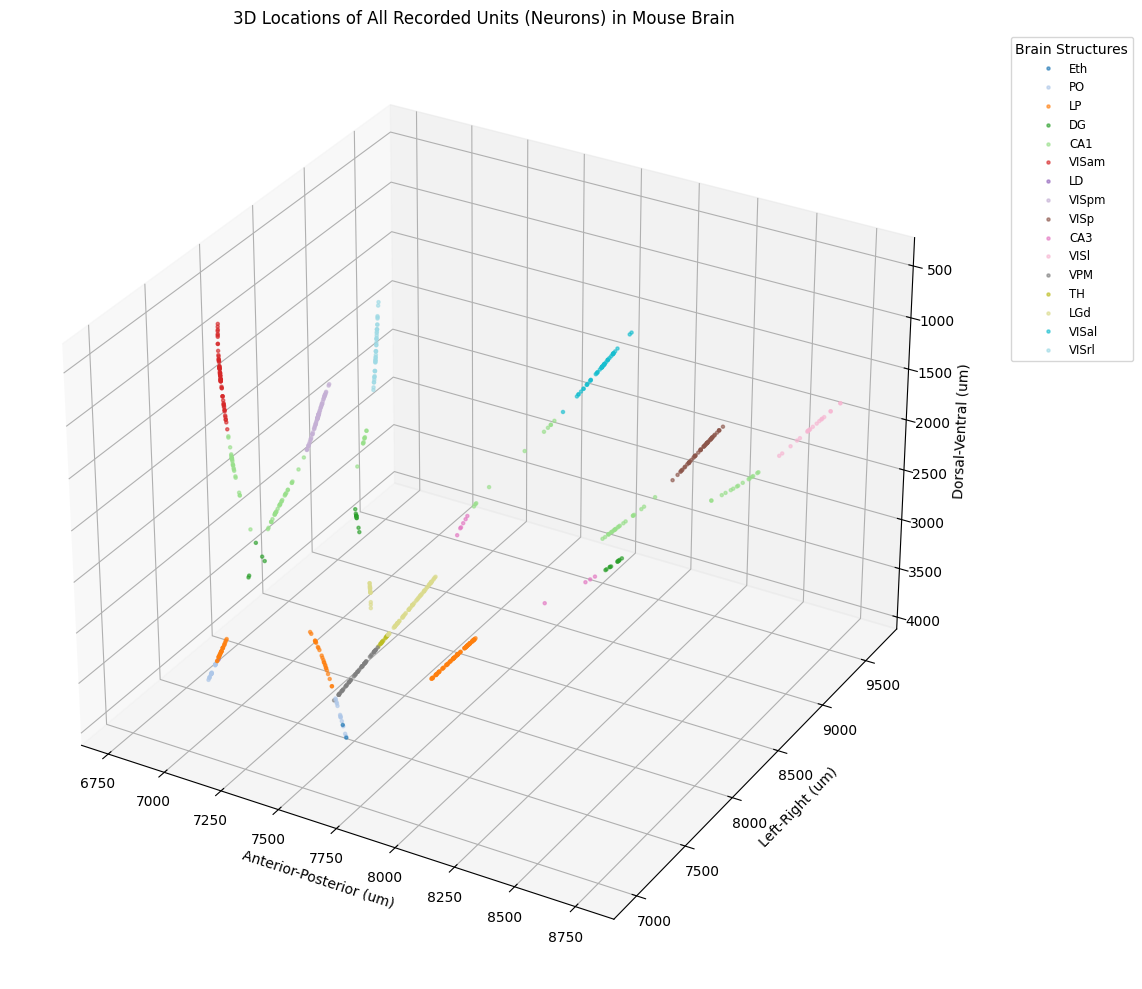

In [31]:
from mpl_toolkits.mplot3d import Axes3D

units_with_loc = session.units.dropna(subset=[
    'anterior_posterior_ccf_coordinate', 
    'dorsal_ventral_ccf_coordinate', 
    'left_right_ccf_coordinate'
])

print(f"Plotting {len(units_with_loc)} units with location data...")

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

structures = units_with_loc['ecephys_structure_acronym'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(structures)))

for i, structure in enumerate(structures):
    structure_units = units_with_loc[units_with_loc['ecephys_structure_acronym'] == structure]
    
    x = structure_units['anterior_posterior_ccf_coordinate']
    y = structure_units['left_right_ccf_coordinate']
    z = structure_units['dorsal_ventral_ccf_coordinate']
    
    ax.scatter(x, y, z, label=structure, s=5, alpha=0.6, color=colors[i])

ax.set_xlabel('Anterior-Posterior (um)')
ax.set_ylabel('Left-Right (um)')
ax.set_zlabel('Dorsal-Ventral (um)')

ax.invert_zaxis()

ax.set_title('3D Locations of All Recorded Units (Neurons) in Mouse Brain')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', title="Brain Structures")

plt.tight_layout()
plt.show()

In [32]:
output_base_dir = Path("../Dataset/Processed") / str(session_id)
output_base_dir.mkdir(parents=True, exist_ok=True)
print(f"Output directory created: {output_base_dir}")

meta_cols = [
    'probe_vertical_position',
    'anterior_posterior_ccf_coordinate',
    'dorsal_ventral_ccf_coordinate',
    'left_right_ccf_coordinate',
    'ecephys_structure_acronym'
]

for probe_id, probe_info in session.probes.iterrows():
    probe_name = probe_info['description']
    filename = f"{probe_name}.csv"
    filepath = output_base_dir / filename
    
    print(f"\nProcessing {probe_name} (ID: {probe_id})...")
    
    probe_units = session.units[session.units['probe_id'] == probe_id]
    
    if probe_units.empty:
        print(f"  No units found for {probe_name}. Skipping.")
        continue
        
    df_meta = probe_units[meta_cols].copy()
    
    valid_units = [u for u in probe_units.index if u in average_response_matrix_total.columns]
    
    if not valid_units:
        print(f"  No response data found for units in {probe_name}.")
        continue
        
    df_response_subset = average_response_matrix_total[valid_units].T
    
    df_response_subset.columns = [f"frame_{i}" for i in df_response_subset.columns]
    
    df_export = df_meta.loc[valid_units].join(df_response_subset)
    
    df_export.index.name = 'id'
    df_export.reset_index(inplace=True)
    
    df_export.to_csv(filepath, index=False)
    print(f"  Saved {len(df_export)} units to {filepath}")
    
print("\nAll exports completed.")

Output directory created: ../Dataset/Processed/750749662

Processing probeA (ID: 769322802)...
  Saved 130 units to ../Dataset/Processed/750749662/probeA.csv

Processing probeB (ID: 769322804)...
  Saved 144 units to ../Dataset/Processed/750749662/probeB.csv

Processing probeC (ID: 769322806)...
  Saved 130 units to ../Dataset/Processed/750749662/probeA.csv

Processing probeB (ID: 769322804)...
  Saved 144 units to ../Dataset/Processed/750749662/probeB.csv

Processing probeC (ID: 769322806)...
  Saved 165 units to ../Dataset/Processed/750749662/probeC.csv

Processing probeD (ID: 769322808)...
  Saved 50 units to ../Dataset/Processed/750749662/probeD.csv

Processing probeE (ID: 769322810)...
  Saved 197 units to ../Dataset/Processed/750749662/probeE.csv

Processing probeF (ID: 769322812)...
  Saved 75 units to ../Dataset/Processed/750749662/probeF.csv

All exports completed.
  Saved 165 units to ../Dataset/Processed/750749662/probeC.csv

Processing probeD (ID: 769322808)...
  Saved 50 u

In [33]:
output_base_dir = Path("../Dataset/Processed") / str(session_id)
output_base_dir.mkdir(parents=True, exist_ok=True)

for probe_id, probe_info in session.probes.iterrows():
    probe_name = probe_info['description']
    filename = f"{probe_name}_sorted_rates.csv"
    filepath = output_base_dir / filename
    
    print(f"\nProcessing {probe_name} (ID: {probe_id}) - Sorted by Depth...")
    
    probe_units = session.units[session.units['probe_id'] == probe_id]
    probe_units_sorted = probe_units.sort_values(by='probe_vertical_position', ascending=False)
    
    if probe_units_sorted.empty:
        print(f"  No units found. Skipping.")
        continue
        
    valid_units = [u for u in probe_units_sorted.index if u in average_response_matrix_total.columns]
    
    if not valid_units:
        print(f"  No response data found.")
        continue
        
    df_response_sorted = average_response_matrix_total[valid_units].T
    
    df_response_sorted.columns = [f"frame_{i}" for i in df_response_sorted.columns]
    
    df_export = df_response_sorted.reset_index()
    df_export.columns.values[0] = 'unit_id'
    
    df_export.to_csv(filepath, index=False)
    print(f"  Saved sorted rates ({len(df_export)} units) to {filepath}")

print("\nSorted export completed.")


Processing probeA (ID: 769322802) - Sorted by Depth...
  Saved sorted rates (130 units) to ../Dataset/Processed/750749662/probeA_sorted_rates.csv

Processing probeB (ID: 769322804) - Sorted by Depth...
  Saved sorted rates (144 units) to ../Dataset/Processed/750749662/probeB_sorted_rates.csv

Processing probeC (ID: 769322806) - Sorted by Depth...
  Saved sorted rates (144 units) to ../Dataset/Processed/750749662/probeB_sorted_rates.csv

Processing probeC (ID: 769322806) - Sorted by Depth...
  Saved sorted rates (165 units) to ../Dataset/Processed/750749662/probeC_sorted_rates.csv

Processing probeD (ID: 769322808) - Sorted by Depth...
  Saved sorted rates (50 units) to ../Dataset/Processed/750749662/probeD_sorted_rates.csv

Processing probeE (ID: 769322810) - Sorted by Depth...
  Saved sorted rates (165 units) to ../Dataset/Processed/750749662/probeC_sorted_rates.csv

Processing probeD (ID: 769322808) - Sorted by Depth...
  Saved sorted rates (50 units) to ../Dataset/Processed/7507496

### Step 3: Linear Dimensionality Reduction (PCA)
Apply PCA to reduce the high-dimensional neural activity into 3 principal components for initial visualization.

Original Shape: (900, 761)
Reduced Shape: (900, 3)
Explained Variance Ratio: [0.05366656 0.02719793 0.02211458] (Total: 10.30%)


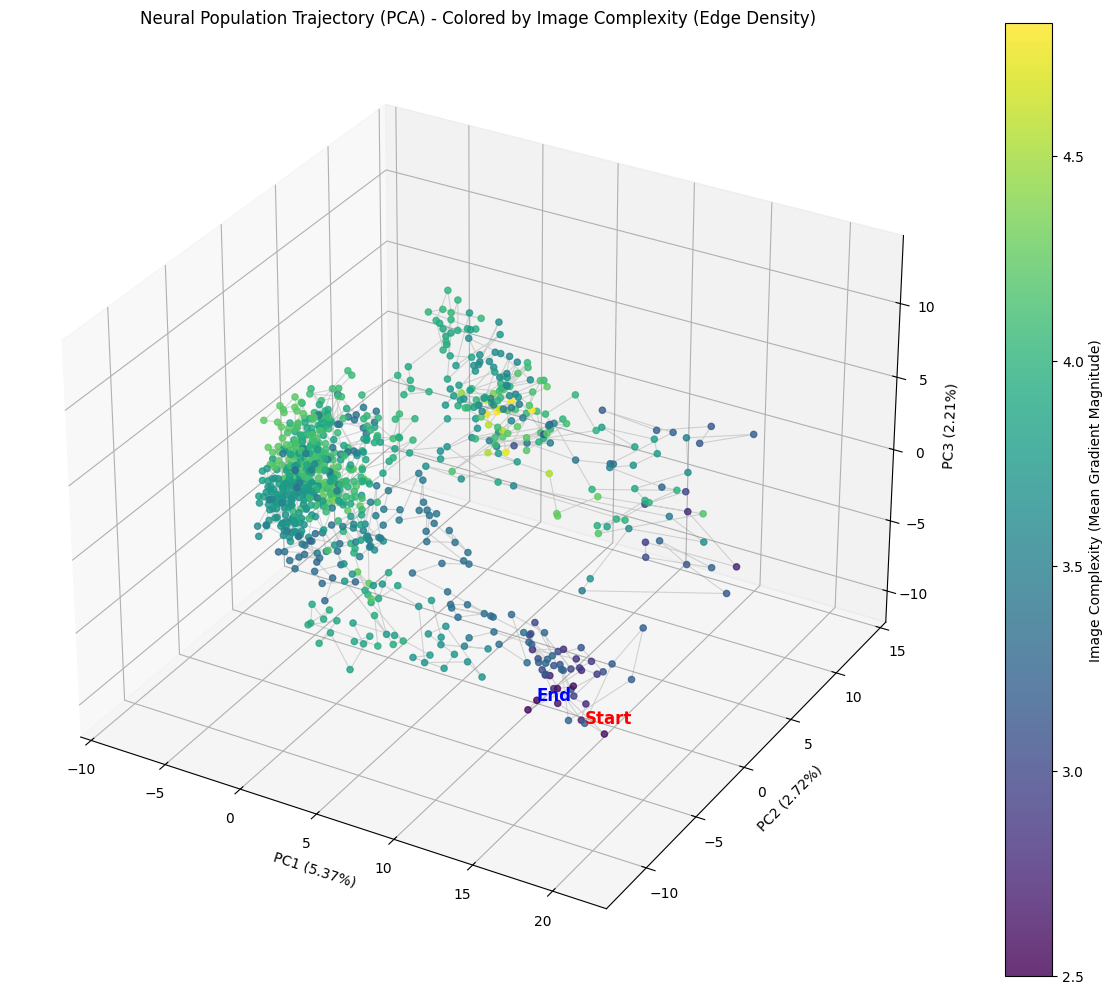

In [34]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = average_response_matrix_total.values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print(f"Original Shape: {X.shape}")
print(f"Reduced Shape: {X_pca.shape}")
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_} (Total: {sum(pca.explained_variance_ratio_):.2%})")

movie_template = cache.get_natural_movie_template(1)

def get_image_complexity(img):
    gy, gx = np.gradient(img)
    gnorm = np.sqrt(gx**2 + gy**2)
    return np.mean(gnorm)

frame_complexity = np.array([get_image_complexity(frame) for frame in movie_template])

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=frame_complexity, cmap='viridis', s=20, alpha=0.8)

ax.plot(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], color='gray', alpha=0.3, linewidth=0.8)

ax.text(X_pca[0, 0], X_pca[0, 1], X_pca[0, 2], "Start", color='red', fontsize=12, fontweight='bold')
ax.text(X_pca[-1, 0], X_pca[-1, 1], X_pca[-1, 2], "End", color='blue', fontsize=12, fontweight='bold')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%})')
ax.set_title('Neural Population Trajectory (PCA) - Colored by Image Complexity (Edge Density)')

plt.colorbar(sc, label='Image Complexity (Mean Gradient Magnitude)')
plt.tight_layout()
plt.show()

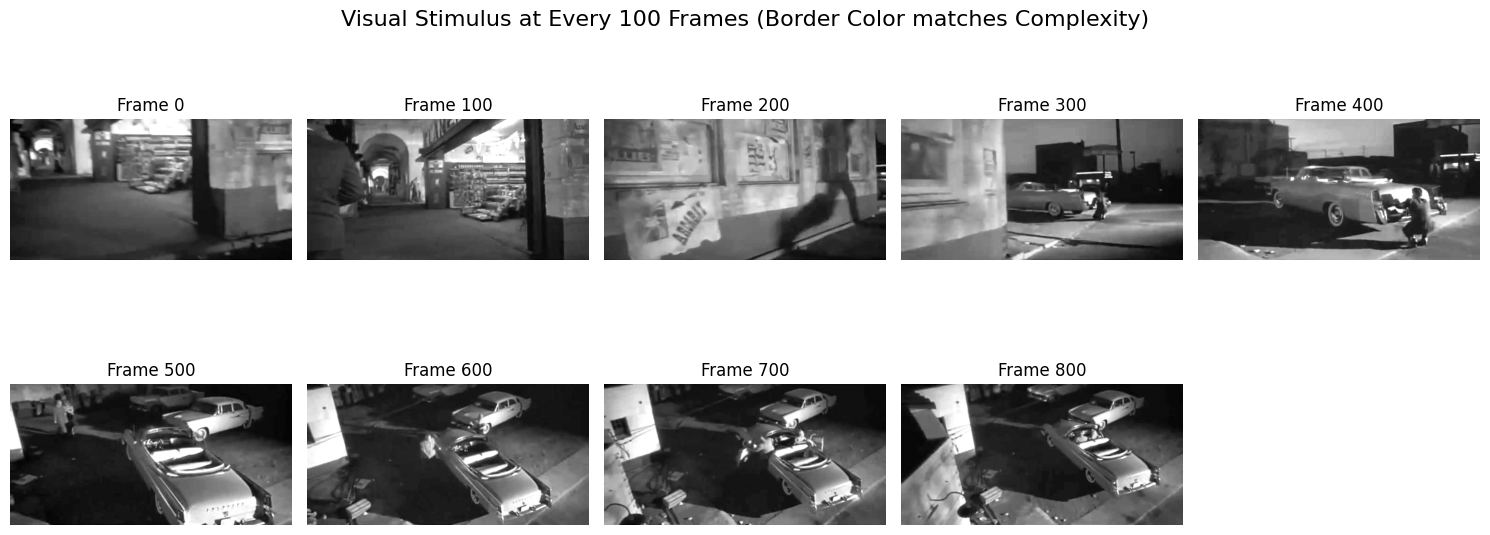

In [35]:
movie_template = cache.get_natural_movie_template(1)
total_frames = movie_template.shape[0]

def get_image_complexity(img):
    gy, gx = np.gradient(img)
    gnorm = np.sqrt(gx**2 + gy**2)
    return np.mean(gnorm)

frame_complexity = np.array([get_image_complexity(frame) for frame in movie_template])
min_c, max_c = frame_complexity.min(), frame_complexity.max()

interval = 100
sample_frames = np.arange(0, total_frames, interval)

cols = 5
rows = (len(sample_frames) // cols) + 1

fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
axes = axes.flatten()

for i, frame_idx in enumerate(sample_frames):
    if frame_idx < total_frames:
        img = movie_template[frame_idx, :, :]
        
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Frame {frame_idx}")
        axes[i].axis('off')
        
        norm_complexity = (frame_complexity[frame_idx] - min_c) / (max_c - min_c)
        color = plt.cm.viridis(norm_complexity)
        for spine in axes[i].spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle(f"Visual Stimulus at Every {interval} Frames (Border Color matches Complexity)", fontsize=16, y=1.02)
plt.show()

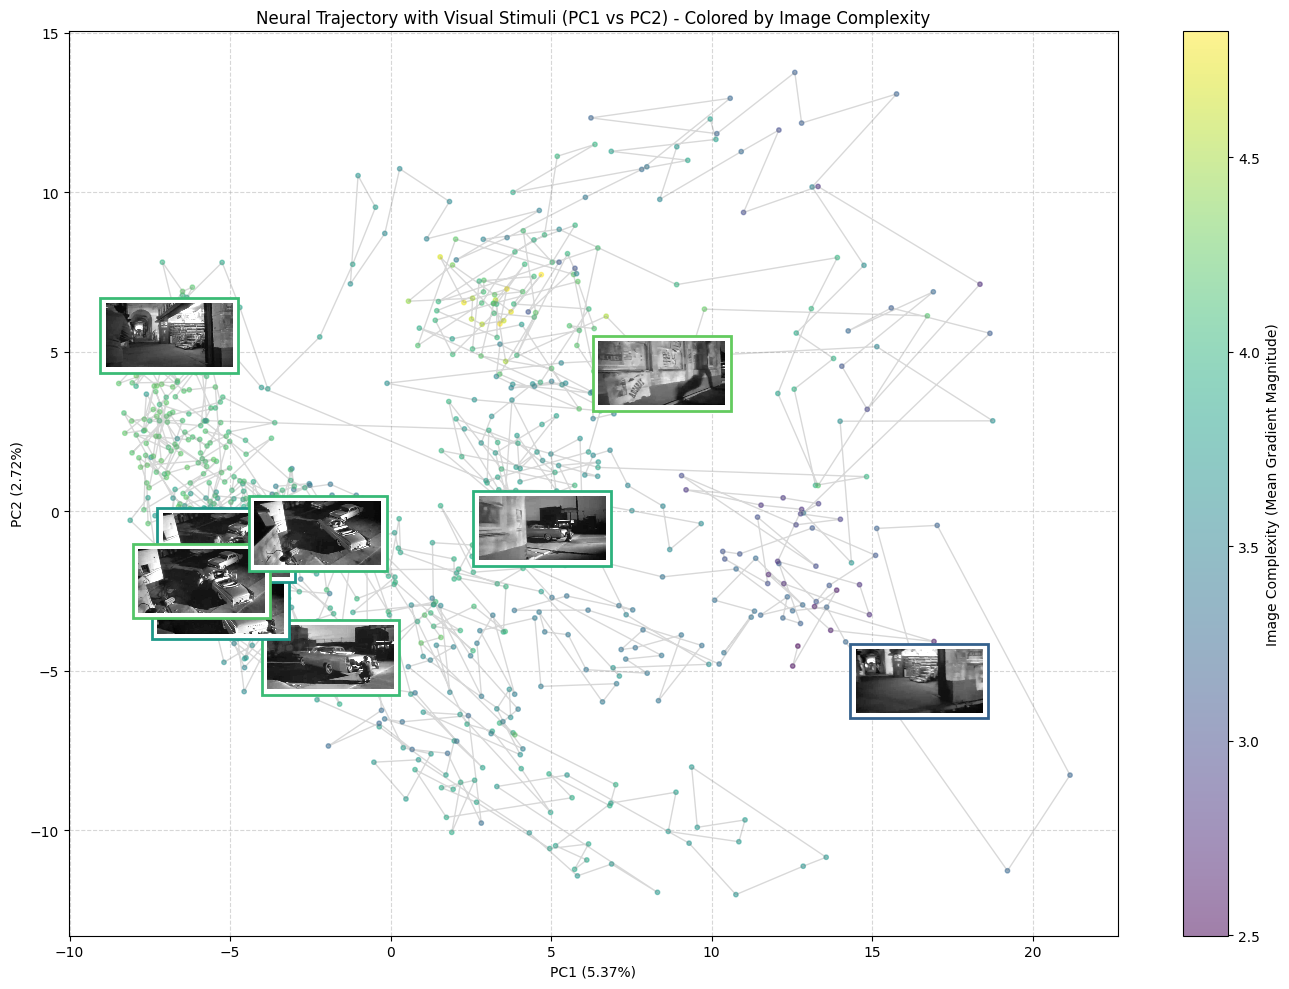

In [36]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

interval = 100
zoom = 0.15

def get_image_complexity(img):
    gy, gx = np.gradient(img)
    gnorm = np.sqrt(gx**2 + gy**2)
    return np.mean(gnorm)

frame_complexity = np.array([get_image_complexity(frame) for frame in movie_template])
min_c, max_c = frame_complexity.min(), frame_complexity.max()

fig, ax = plt.subplots(figsize=(14, 10))

sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=frame_complexity, cmap='viridis', s=10, alpha=0.5)
ax.plot(X_pca[:, 0], X_pca[:, 1], color='gray', alpha=0.3, linewidth=1)

for i in range(0, total_frames, interval):
    x, y = X_pca[i, 0], X_pca[i, 1]
    
    img = movie_template[i, :, :]
    
    im = OffsetImage(img, zoom=zoom, cmap='gray')
    
    norm_complexity = (frame_complexity[i] - min_c) / (max_c - min_c)
    color = plt.cm.viridis(norm_complexity)
    
    ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=True,
                        bboxprops=dict(edgecolor=color, linewidth=2))
    
    ax.add_artist(ab)
    
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
ax.set_title(f'Neural Trajectory with Visual Stimuli (PC1 vs PC2) - Colored by Image Complexity')

plt.colorbar(sc, label='Image Complexity (Mean Gradient Magnitude)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

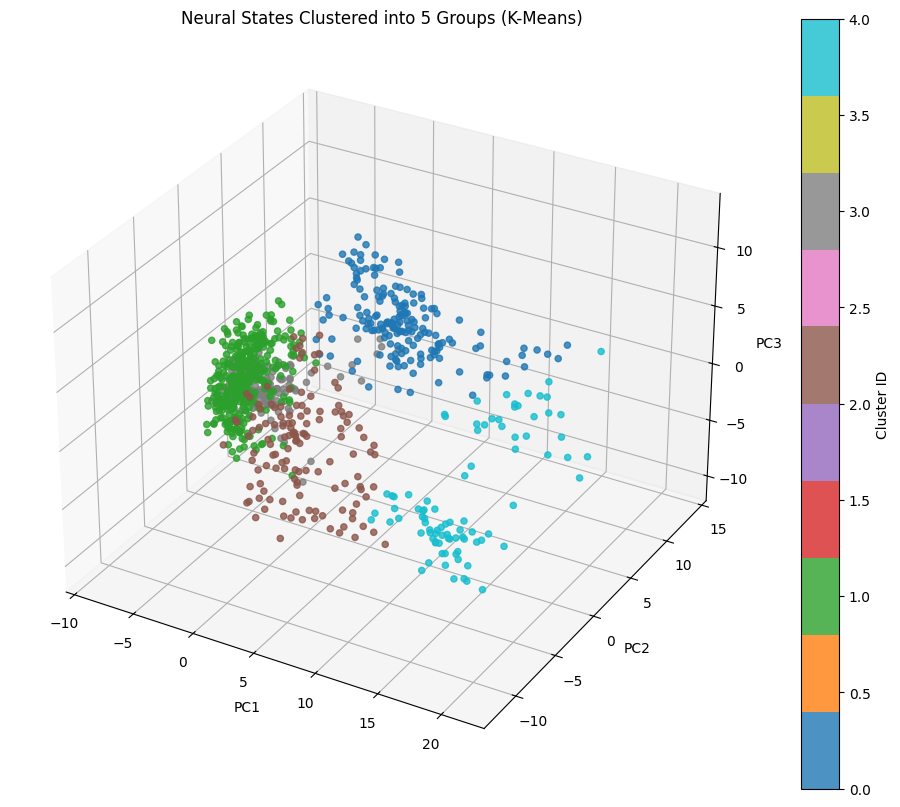

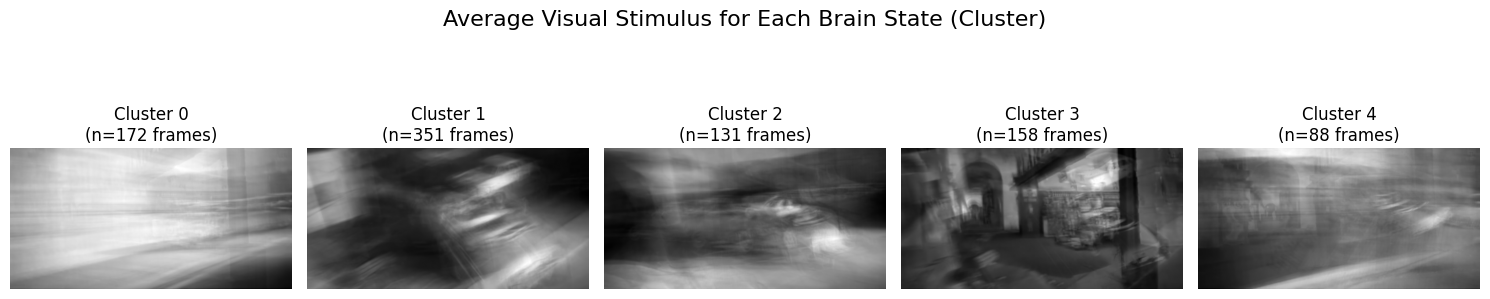

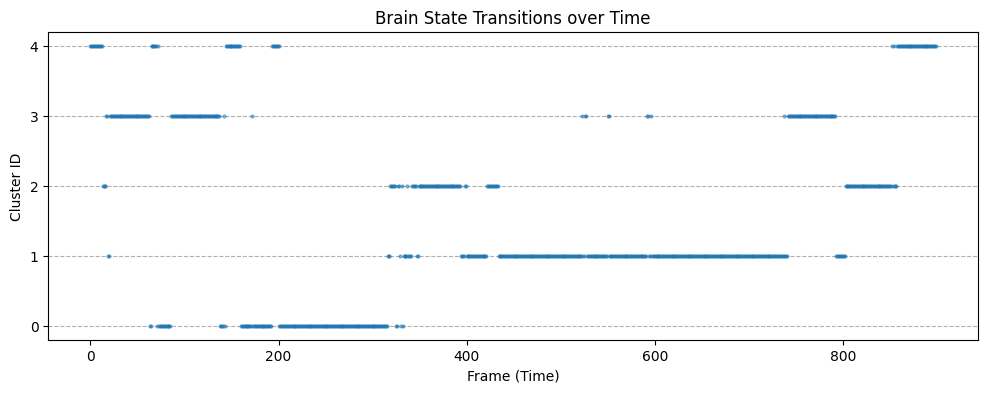

In [37]:
from sklearn.cluster import KMeans

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=cluster_labels, cmap='tab10', s=20, alpha=0.8)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title(f'Neural States Clustered into {n_clusters} Groups (K-Means)')
plt.colorbar(scatter, label='Cluster ID')
plt.show()

fig, axes = plt.subplots(1, n_clusters, figsize=(15, 4))
fig.suptitle(f"Average Visual Stimulus for Each Brain State (Cluster)", fontsize=16)

for i in range(n_clusters):
    indices = np.where(cluster_labels == i)[0]
    
    if len(indices) > 0:
        mean_image = np.mean(movie_template[indices], axis=0)
        
        axes[i].imshow(mean_image, cmap='gray')
        axes[i].set_title(f"Cluster {i}\n(n={len(indices)} frames)")
        axes[i].axis('off')
    else:
        axes[i].text(0.5, 0.5, "No Data", ha='center')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(cluster_labels, marker='o', linestyle='None', markersize=2, alpha=0.5)
plt.xlabel("Frame (Time)")
plt.ylabel("Cluster ID")
plt.title("Brain State Transitions over Time")
plt.yticks(range(n_clusters))
plt.grid(axis='y', linestyle='--')
plt.show()

Original Shape: (900, 761)
Reduced Shape: (900, 3)
Explained Variance Ratio: [0.05366656 0.02719793 0.02211459] (Total: 10.30%)


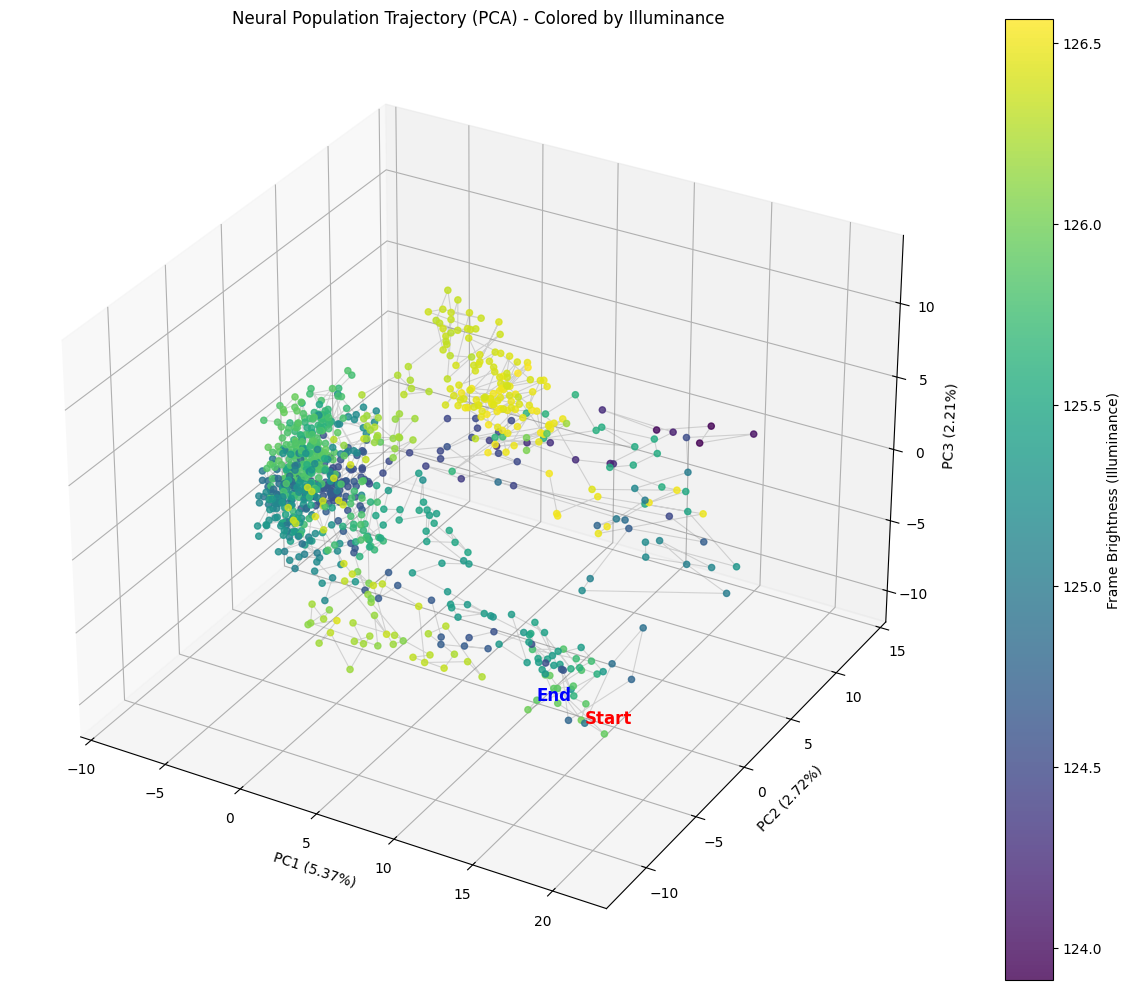

In [38]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. 데이터 준비 및 PCA 수행
X = average_response_matrix_total.values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print(f"Original Shape: {X.shape}")
print(f"Reduced Shape: {X_pca.shape}")
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_} (Total: {sum(pca.explained_variance_ratio_):.2%})")

# 2. 프레임별 밝기(Illuminance) 계산
# (Frames, Height, Width) -> (Frames,) : 각 프레임의 픽셀 평균값
movie_template = cache.get_natural_movie_template(1)
frame_brightness = np.mean(movie_template, axis=(1, 2))

# 3. 3D 시각화
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 색상(c)을 프레임의 밝기로 설정
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=frame_brightness, cmap='viridis', s=20, alpha=0.8)

# 궤적 선 그리기
ax.plot(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], color='gray', alpha=0.3, linewidth=0.8)

# 시작/끝 표시
ax.text(X_pca[0, 0], X_pca[0, 1], X_pca[0, 2], "Start", color='red', fontsize=12, fontweight='bold')
ax.text(X_pca[-1, 0], X_pca[-1, 1], X_pca[-1, 2], "End", color='blue', fontsize=12, fontweight='bold')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%})')
ax.set_title('Neural Population Trajectory (PCA) - Colored by Illuminance')

plt.colorbar(sc, label='Frame Brightness (Illuminance)')
plt.tight_layout()
plt.show()

Text(0, 0.5, 'PC2 (2.72%)')

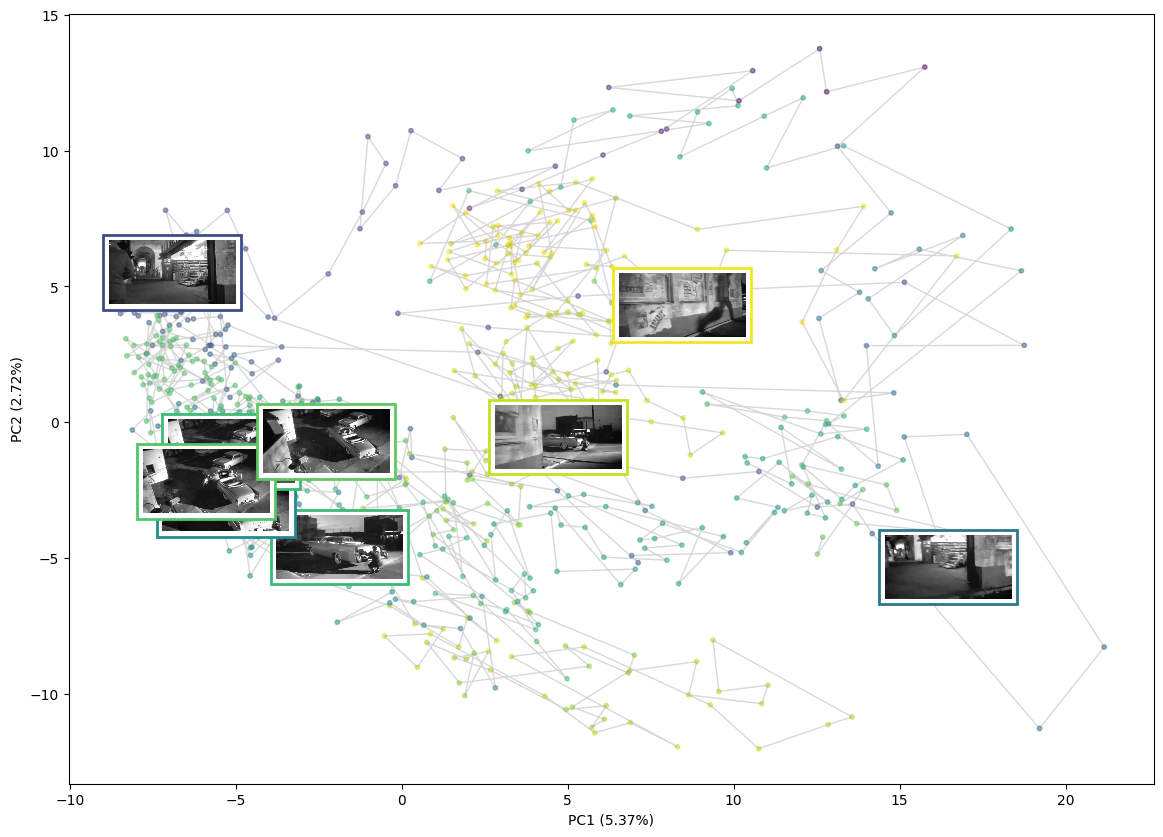

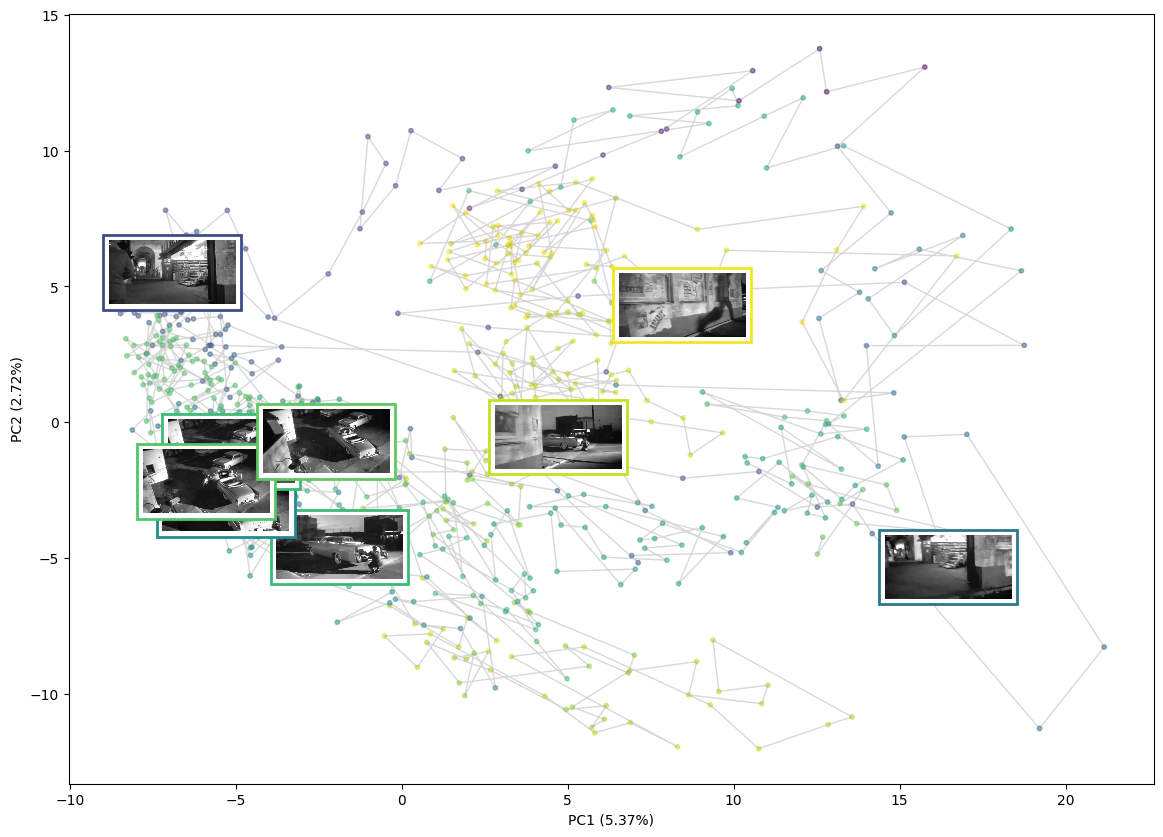

In [39]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

interval = 100
zoom = 0.15

# 밝기 계산 및 정규화 (0~1 사이 값으로 변환하여 컬러맵 적용)
frame_brightness = np.mean(movie_template, axis=(1, 2))
min_b, max_b = frame_brightness.min(), frame_brightness.max()

fig, ax = plt.subplots(figsize=(14, 10))

# 배경 산점도 (밝기 기준 색상)
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=frame_brightness, cmap='viridis', s=10, alpha=0.5)
ax.plot(X_pca[:, 0], X_pca[:, 1], color='gray', alpha=0.3, linewidth=1)

# 이미지 콜라주
for i in range(0, total_frames, interval):
    x, y = X_pca[i, 0], X_pca[i, 1]
    
    img = movie_template[i, :, :]
    
    im = OffsetImage(img, zoom=zoom, cmap='gray')
    
    # 해당 프레임의 밝기에 맞는 색상 추출
    norm_brightness = (frame_brightness[i] - min_b) / (max_b - min_b)
    color = plt.cm.viridis(norm_brightness)
    
    # 테두리 색상 적용
    ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=True,
                        bboxprops=dict(edgecolor=color, linewidth=2))
    
    ax.add_artist(ab)
    
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
#ax.set_title(f'Neural Trajectory with Visual Stimuli (PCfrom matplotlib.offsetbox import OffsetImage, AnnotationBbox

interval = 100
zoom = 0.15

# 밝기 계산 및 정규화 (0~1 사이 값으로 변환하여 컬러맵 적용)
frame_brightness = np.mean(movie_template, axis=(1, 2))
min_b, max_b = frame_brightness.min(), frame_brightness.max()

fig, ax = plt.subplots(figsize=(14, 10))

# 배경 산점도 (밝기 기준 색상)
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=frame_brightness, cmap='viridis', s=10, alpha=0.5)
ax.plot(X_pca[:, 0], X_pca[:, 1], color='gray', alpha=0.3, linewidth=1)

# 이미지 콜라주
for i in range(0, total_frames, interval):
    x, y = X_pca[i, 0], X_pca[i, 1]
    
    img = movie_template[i, :, :]
    
    im = OffsetImage(img, zoom=zoom, cmap='gray')
    
    # 해당 프레임의 밝기에 맞는 색상 추출
    norm_brightness = (frame_brightness[i] - min_b) / (max_b - min_b)
    color = plt.cm.viridis(norm_brightness)
    
    # 테두리 색상 적용
    ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=True,
                        bboxprops=dict(edgecolor=color, linewidth=2))
    
    ax.add_artist(ab)
    
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
#ax.set_title(f'Neural Trajectory with Visual Stimuli (PC

Original Shape: (900, 761)
Reduced Shape: (900, 3)
Explained Variance Ratio: [0.05366656 0.02719793 0.02211459] (Total: 10.30%)


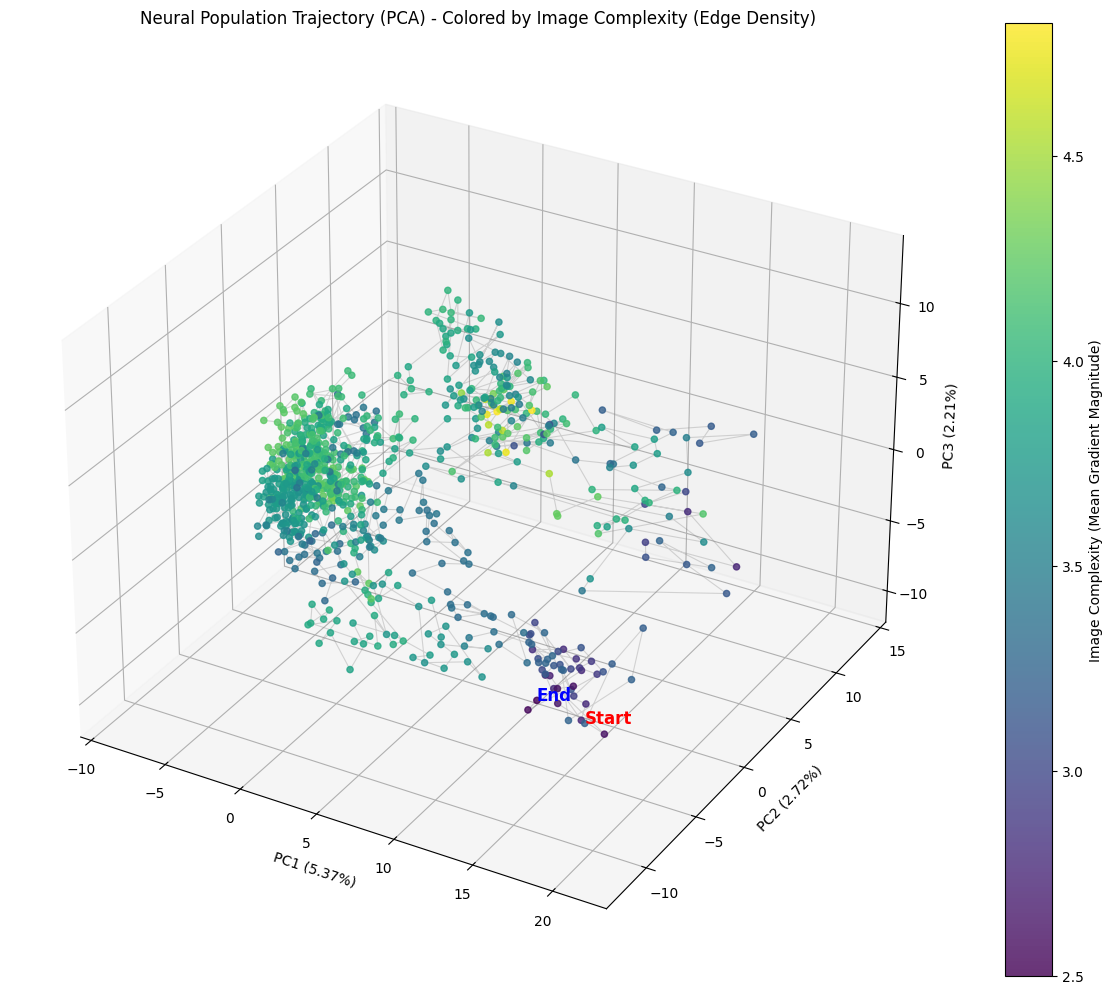

In [40]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. 데이터 준비 및 PCA
X = average_response_matrix_total.values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print(f"Original Shape: {X.shape}")
print(f"Reduced Shape: {X_pca.shape}")
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_} (Total: {sum(pca.explained_variance_ratio_):.2%})")

# 2. 이미지 복잡도(Complexity) 계산 함수
# Gradient Magnitude(변화량의 크기)를 사용하여 엣지(Edge) 밀도를 측정합니다.
movie_template = cache.get_natural_movie_template(1)

def get_image_complexity(img):
    gy, gx = np.gradient(img)       # y방향, x방향 변화량 계산
    gnorm = np.sqrt(gx**2 + gy**2)  # 변화량 벡터의 크기 (Magnitude)
    return np.mean(gnorm)           # 전체 평균을 복잡도 지표로 사용

# 모든 프레임에 대해 복잡도 계산
frame_complexity = np.array([get_image_complexity(frame) for frame in movie_template])

# 3. 3D 시각화
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 색상(c)을 이미지 복잡도로 설정
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=frame_complexity, cmap='viridis', s=20, alpha=0.8)

ax.plot(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], color='gray', alpha=0.3, linewidth=0.8)

ax.text(X_pca[0, 0], X_pca[0, 1], X_pca[0, 2], "Start", color='red', fontsize=12, fontweight='bold')
ax.text(X_pca[-1, 0], X_pca[-1, 1], X_pca[-1, 2], "End", color='blue', fontsize=12, fontweight='bold')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%})')
ax.set_title('Neural Population Trajectory (PCA) - Colored by Image Complexity (Edge Density)')

plt.colorbar(sc, label='Image Complexity (Mean Gradient Magnitude)')
plt.tight_layout()
plt.show()

In [41]:
# --- PCA 궤적 데이터 내보내기 (Export Trajectory Data) ---
# PC1, PC2, PC3 좌표를 CSV 파일로 저장합니다.

# 1. 저장 경로 설정 (기존과 동일)
output_base_dir = Path("../Dataset/Processed") / str(session_id)
output_base_dir.mkdir(parents=True, exist_ok=True)

# 2. 데이터프레임 생성
# X_pca는 (Frames x 3) 크기의 배열입니다.
df_trajectory = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])

# 프레임 번호 추가
df_trajectory['frame'] = np.arange(len(df_trajectory))

# (선택사항) 분석에 사용된 밝기(Brightness)와 복잡도(Complexity)도 함께 저장
if 'frame_brightness' in locals():
    df_trajectory['brightness'] = frame_brightness
if 'frame_complexity' in locals():
    df_trajectory['complexity'] = frame_complexity

# 3. CSV 파일로 저장
filename = "neural_trajectory_pca_3d.csv"
filepath = output_base_dir / filename

df_trajectory.to_csv(filepath, index=False)
print(f"Trajectory data saved to: {filepath}")
display(df_trajectory.head())

Trajectory data saved to: ../Dataset/Processed/750749662/neural_trajectory_pca_3d.csv


PC1        PC2       PC3  frame  brightness  complexity
0  16.451624  -5.326400 -7.896282      0  124.967727    3.209064
1  15.140078  -0.538898 -7.385316      1  124.893217    3.188529
2  17.023618  -0.444649 -4.351390      2  124.889229    3.194047
3  21.160480  -8.273505 -1.393154      3  124.789598    3.224227
4  19.212171 -11.271027 -2.778832      4  124.782240    3.240438

=== Focusing analysis on VISp area only ===
Selected 52 units from VISp
VISp Explained Variance: [0.13282288 0.09051626 0.05989149] (Total: 28.32%)
VISp Explained Variance: [0.13282288 0.09051626 0.05989149] (Total: 28.32%)


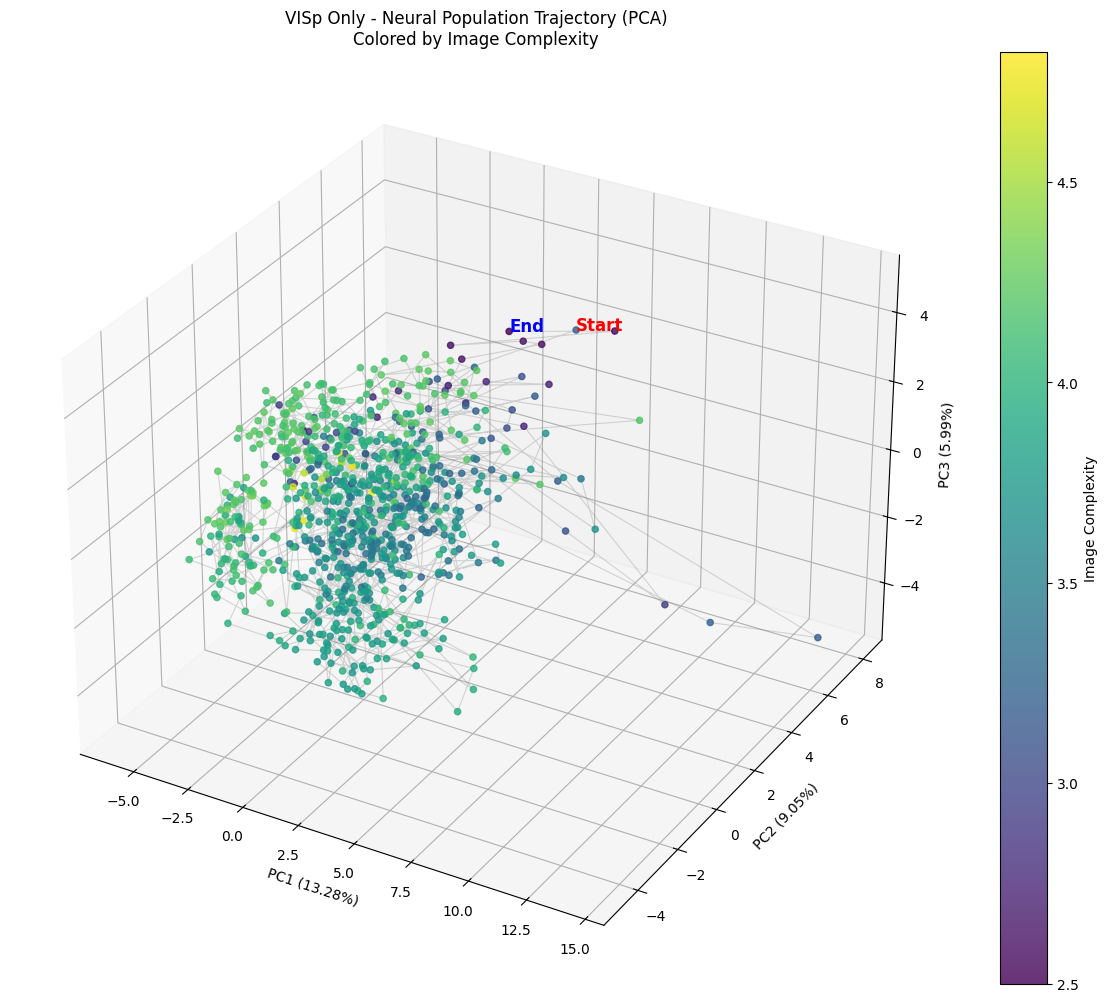

VISp Trajectory data saved to: ../Dataset/Processed/750749662/neural_trajectory_visp_pca_3d.csv


PC1       PC2       PC3  frame  brightness  complexity
0   2.879376  7.543938  1.991463      0  124.967727    3.209064
1  -1.059074  4.842465  1.148616      1  124.893217    3.188529
2   1.903970  7.762852 -2.836403      2  124.889229    3.194047
3  14.306824  7.253024 -4.968465      3  124.789598    3.224227
4  11.712217  4.460021 -3.507715      4  124.782240    3.240438

In [42]:
# --- VISp 영역 전용 분석 (VISp Only Analysis) ---
print("=== Focusing analysis on VISp area only ===")

# 1. VISp 유닛 데이터 준비 및 응답 매트릭스 생성
visp_units = session.units[session.units["ecephys_structure_acronym"] == "VISp"]
print(f"Selected {len(visp_units)} units from VISp")

# VISp 유닛들에 대한 스파이크 카운트 계산
spike_counts_visp = session.presentationwise_spike_counts(
    stimulus_presentation_ids=movie_table.index.values,
    bin_edges=np.array([0, frame_duration]),
    unit_ids=visp_units.index.values
)

# 시간 차원 합산 및 데이터프레임 변환
response_matrix_visp = spike_counts_visp.sum(dim="time_relative_to_stimulus_onset")
df_response_visp = pd.DataFrame(
    response_matrix_visp.values,
    index=movie_table.index,
    columns=visp_units.index
)
df_response_visp['frame'] = movie_table['frame']
average_response_matrix_visp = df_response_visp.groupby('frame').mean()

# 2. PCA 수행 (VISp 데이터)
X_visp = average_response_matrix_visp.values
scaler_visp = StandardScaler()
X_visp_scaled = scaler_visp.fit_transform(X_visp)

pca_visp = PCA(n_components=3)
X_visp_pca = pca_visp.fit_transform(X_visp_scaled)

print(f"VISp Explained Variance: {pca_visp.explained_variance_ratio_} (Total: {sum(pca_visp.explained_variance_ratio_):.2%})")

# 3. 3D 시각화 (Complexity 기준)
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# frame_complexity가 정의되어 있다고 가정 (이전 셀에서 계산됨)
if 'frame_complexity' not in locals():
    print("Recalculating frame complexity...")
    frame_complexity = np.array([get_image_complexity(frame) for frame in movie_template])

sc = ax.scatter(X_visp_pca[:, 0], X_visp_pca[:, 1], X_visp_pca[:, 2], c=frame_complexity, cmap='viridis', s=20, alpha=0.8)
ax.plot(X_visp_pca[:, 0], X_visp_pca[:, 1], X_visp_pca[:, 2], color='gray', alpha=0.3, linewidth=0.8)

# 시작/끝 표시
ax.text(X_visp_pca[0, 0], X_visp_pca[0, 1], X_visp_pca[0, 2], "Start", color='red', fontsize=12, fontweight='bold')
ax.text(X_visp_pca[-1, 0], X_visp_pca[-1, 1], X_visp_pca[-1, 2], "End", color='blue', fontsize=12, fontweight='bold')

ax.set_xlabel(f'PC1 ({pca_visp.explained_variance_ratio_[0]:.2%})')
ax.set_ylabel(f'PC2 ({pca_visp.explained_variance_ratio_[1]:.2%})')
ax.set_zlabel(f'PC3 ({pca_visp.explained_variance_ratio_[2]:.2%})')
ax.set_title('VISp Only - Neural Population Trajectory (PCA)\nColored by Image Complexity')

plt.colorbar(sc, label='Image Complexity')
plt.tight_layout()
plt.show()

# 4. VISp 데이터 내보내기
df_visp_trajectory = pd.DataFrame(X_visp_pca, columns=['PC1', 'PC2', 'PC3'])
df_visp_trajectory['frame'] = np.arange(len(df_visp_trajectory))

if 'frame_brightness' in locals():
    df_visp_trajectory['brightness'] = frame_brightness
if 'frame_complexity' in locals():
    df_visp_trajectory['complexity'] = frame_complexity

visp_filename = "neural_trajectory_visp_pca_3d.csv"
visp_filepath = output_base_dir / visp_filename
df_visp_trajectory.to_csv(visp_filepath, index=False)
print(f"VISp Trajectory data saved to: {visp_filepath}")
display(df_visp_trajectory.head())

### Step 4: Topological Data Analysis (TDA)
Compute Persistent Homology to identify topological features (loops, voids) that persist across scales.

ripser and persim libraries found.
Data shape for TDA: (900, 10) (PCA Top 10 components)
Explained Variance: 53.38%
Computing Persistent Homology (this may take a moment)...


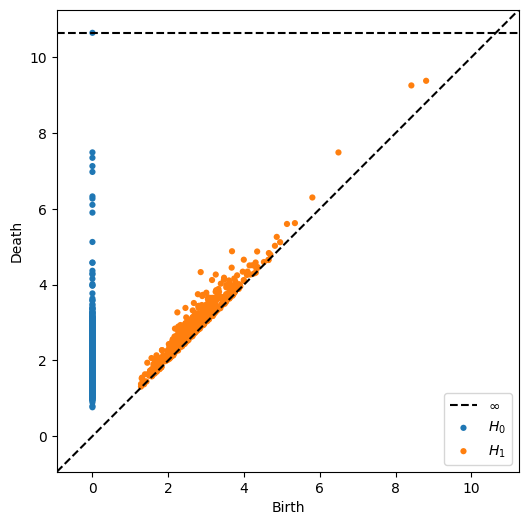

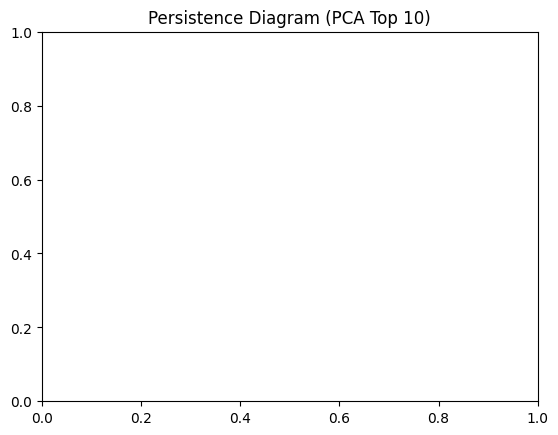

In [43]:
# --- TDA (Topological Data Analysis) - Persistent Homology ---
# 질문에 대한 답변:
# 1. 데이터가 뭉쳐 보일 때: 3차원으로 축소하면서 정보가 손실되었을 수 있습니다. 고차원 위상(Topology)을 보려면 'Persistent Homology'를 사용합니다.
# 2. PCA 후 TDA?: 네, 보통 노이즈를 줄이고 계산 속도를 높이기 위해 PCA로 차원을 어느 정도(예: 10~50차원) 줄인 후 TDA를 수행합니다.

try:
    from ripser import ripser
    from persim import plot_diagrams
    print("ripser and persim libraries found.")
except ImportError:
    print("Installing ripser and persim libraries...")
    import sys
    !{sys.executable} -m pip install ripser persim
    from ripser import ripser
    from persim import plot_diagrams

# 1. TDA를 위한 데이터 준비
# 3차원은 위상 정보를 잃을 수 있고, 전체 차원은 노이즈가 많을 수 있습니다.
# 보통 설명력이 높은 상위 PC들(예: 10~20개)을 사용하여 TDA를 수행합니다.
n_components_tda = 10
pca_tda = PCA(n_components=n_components_tda)
X_tda = pca_tda.fit_transform(X_visp_scaled) # VISp 영역 데이터 사용

print(f"Data shape for TDA: {X_tda.shape} (PCA Top {n_components_tda} components)")
print(f"Explained Variance: {sum(pca_tda.explained_variance_ratio_):.2%}")

# 2. Persistent Homology 계산 (Vietoris-Rips Filtration)
# maxdim=1: H0(연결성/클러스터), H1(루프/구멍)까지 계산합니다.
# H2(보이드/공동)를 보려면 maxdim=2로 설정하세요 (계산 시간이 길어질 수 있음).
print("Computing Persistent Homology (this may take a moment)...")
result = ripser(X_tda, maxdim=1)
diagrams = result['dgms']

# 3. Persistence Diagram 시각화
plt.figure(figsize=(8, 6))
plot_diagrams(diagrams, show=True)
plt.title(f"Persistence Diagram (PCA Top {n_components_tda})")
plt.show()

# --- 해석 가이드 ---
# H0 (파란색 점): 연결된 성분(Connected Components). 
#   - 대각선에서 멀리 떨어진 점이 많으면 데이터가 여러 덩어리(Cluster)로 나뉘어 있다는 뜻입니다.
# H1 (주황색 점): 1차원 구멍(Loops/Cycles). 
#   - 대각선에서 멀리 떨어진 주황색 점이 있다면, 데이터가 고차원에서 '링(Ring)' 또는 '순환' 구조를 형성하고 있다는 강력한 증거입니다.
#   - 모든 점이 대각선 근처에 모여 있다면, 뚜렷한 구멍이 없는(Simply connected) 상태입니다.

### Step 5: Non-linear Manifold Learning (UMAP)
Use UMAP to unfold the neural manifold and reveal complex non-linear structures hidden in the PCA projection.

umap-learn library found.
Running UMAP...


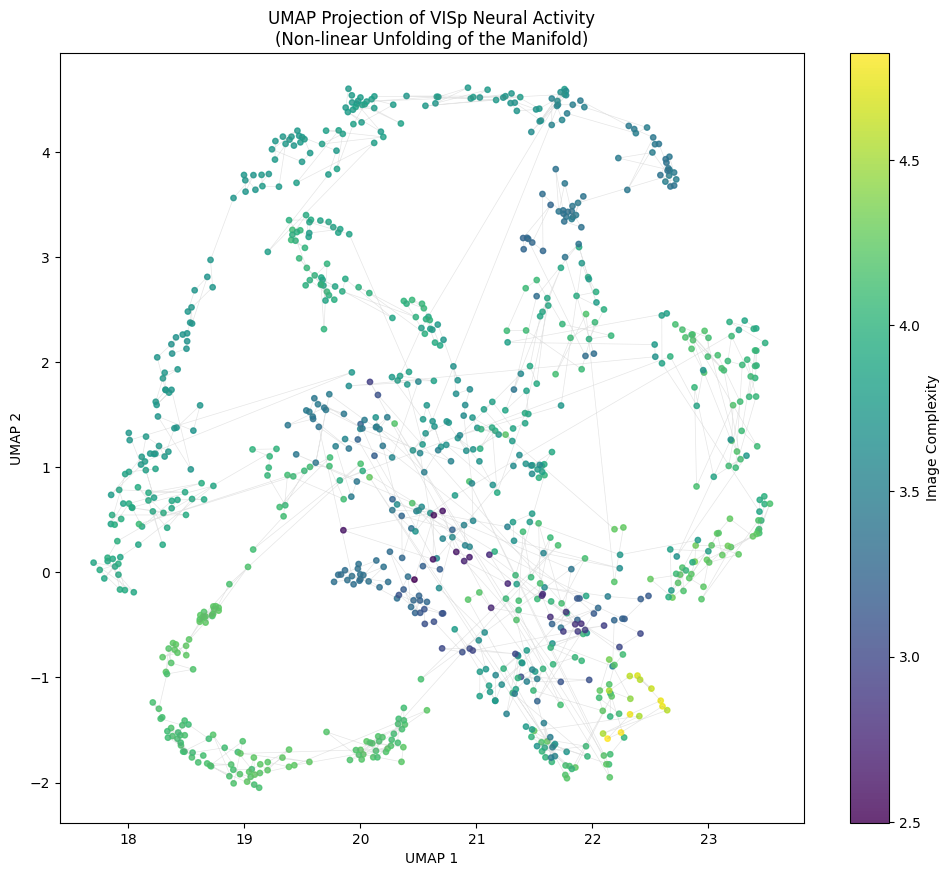

In [44]:
# --- UMAP (Uniform Manifold Approximation and Projection) ---
# 주황색 점이 대각선에 붙어 있다는 것은 뚜렷한 '구멍(Loop)'이 발견되지 않았다는 뜻입니다.
# 즉, 데이터가 도넛 모양보다는 '꽉 찬 공(Ball)'이나 '단순한 덩어리'에 가까운 위상을 가질 가능성이 높습니다.
# 하지만 PCA(선형)가 복잡한 비선형 구조를 뭉개버렸을 수도 있습니다.
# 이럴 때는 비선형 차원 축소 기법인 UMAP을 사용하여 뭉친 데이터를 '펼쳐서' 확인해보는 것이 좋습니다.

try:
    import umap
    print("umap-learn library found.")
except ImportError:
    print("Installing umap-learn library...")
    import sys
    !{sys.executable} -m pip install umap-learn
    import umap

# UMAP 실행 (2차원으로 축소하여 시각화)
# n_neighbors: 이웃의 수 (작으면 로컬 구조, 크면 글로벌 구조 중시. 보통 15~50)
# min_dist: 포인트 간 최소 거리 (작으면 뭉치게, 크면 퍼지게. 보통 0.1)
print("Running UMAP...")
reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(X_visp_scaled)

# 시각화
plt.figure(figsize=(12, 10))
sc = plt.scatter(embedding[:, 0], embedding[:, 1], c=frame_complexity, cmap='viridis', s=15, alpha=0.8)

# 시간의 흐름을 선으로 연결해보기 (너무 복잡하면 주석 처리하세요)
plt.plot(embedding[:, 0], embedding[:, 1], color='gray', alpha=0.2, linewidth=0.5)

plt.colorbar(sc, label='Image Complexity')
plt.title('UMAP Projection of VISp Neural Activity\n(Non-linear Unfolding of the Manifold)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# --- UMAP 해석 ---
# 1. 만약 UMAP에서도 하나의 덩어리라면: 정말로 위상학적으로 단순한 구조일 수 있습니다.
# 2. 만약 길게 늘어지거나 갈라진다면: PCA에서는 겹쳐서 안 보였던 궤적의 진행 방향이 드러난 것입니다.
# 3. 만약 끊어진 섬들이 보인다면: 데이터가 불연속적인 상태(State)들을 오가고 있을 수 있습니다.

In [45]:
# --- UMAP 결과 심층 분석 (Interactive Visualization) ---
# "구멍이 여러 개 있다"는 것은 매우 흥미로운 발견입니다!
# 이는 신경 활동이 단순한 선형 궤적이 아니라, 특정 조건에서 순환하거나(Loop),
# 접근하지 않는 '금지된 영역(Void)'을 피해가는 복잡한 위상을 가짐을 의미합니다.
# PCA(선형)에서는 이 구멍들이 찌그러져서 안 보였던 것입니다.

# 구멍의 정체를 파악하기 위해 Plotly를 사용하여 인터랙티브 그래프를 그려봅니다.
# 마우스를 올리면 몇 번째 프레임인지 확인할 수 있습니다.

try:
    import plotly.express as px
    print("plotly library found.")
except ImportError:
    print("Installing plotly library...")
    import sys
    !{sys.executable} -m pip install plotly
    import plotly.express as px

# 데이터프레임 생성
df_umap = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
df_umap['Frame'] = np.arange(len(df_umap))
df_umap['Complexity'] = frame_complexity
df_umap['Brightness'] = frame_brightness if 'frame_brightness' in locals() else 0

# 1. 시간(Frame)에 따른 흐름 확인
# 구멍을 따라 시간이 흐르는지(순환 구조), 아니면 시간과 무관하게 구멍이 뚫려 있는지 확인합니다.
fig = px.scatter(
    df_umap, x='UMAP1', y='UMAP2', 
    color='Frame', 
    hover_data=['Complexity', 'Brightness'],
    title='UMAP Projection Colored by Time (Frame)',
    color_continuous_scale='Turbo' # 무지개색으로 시간 흐름 강조
)
fig.update_traces(marker=dict(size=3), selector=dict(mode='markers'))
fig.show()

# 2. 복잡도(Complexity) 분포 확인
# 구멍 주변에 복잡도가 높은 이미지들이 모여 있는지 확인합니다.
fig2 = px.scatter(
    df_umap, x='UMAP1', y='UMAP2', 
    color='Complexity', 
    hover_data=['Frame'],
    title='UMAP Projection Colored by Image Complexity',
    color_continuous_scale='Viridis'
)
fig2.update_traces(marker=dict(size=3), selector=dict(mode='markers'))
fig2.show()

# --- 해석 팁 ---
# 1. 시간(Frame) 그래프에서 색깔이 구멍을 빙글빙글 돌고 있나요?
#    -> 그렇다면 뇌가 반복적인 패턴이나 리듬을 타고 있는 것입니다.
# 2. 구멍의 한가운데는 '비어있는' 상태입니다.
#    -> 이 상태는 뇌가 자연스러운 자극을 볼 때 절대 취하지 않는 신경 패턴 조합일 수 있습니다.
# 3. 여러 개의 구멍은 서로 다른 종류의 시각적 특징(예: 텍스처, 밝기 변화 등)을 처리하는
#    서로 다른 '처리 루프'일 수 있습니다.

plotly library found.


In [46]:
# --- 3D UMAP Analysis ---
# 네, UMAP은 n_components 파라미터를 조절하여 3차원(또는 그 이상)으로 차원을 축소할 수 있습니다.
# 3차원 공간에서는 2차원에서 겹쳐 보였던 '구멍'이나 '루프' 구조가 더 명확하게 드러날 수 있습니다.

print("Running 3D UMAP (n_components=3)...")
# 3차원 UMAP 실행
reducer_3d = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=3, random_state=42)
embedding_3d = reducer_3d.fit_transform(X_visp_scaled)

# 데이터프레임 생성
df_umap_3d = pd.DataFrame(embedding_3d, columns=['UMAP1', 'UMAP2', 'UMAP3'])
df_umap_3d['Frame'] = np.arange(len(df_umap_3d))
df_umap_3d['Complexity'] = frame_complexity

# Plotly를 이용한 3D 인터랙티브 시각화
import plotly.express as px

# 1. 시간(Frame) 흐름에 따른 3D 시각화
fig = px.scatter_3d(
    df_umap_3d, x='UMAP1', y='UMAP2', z='UMAP3',
    color='Frame',  # 시간 흐름에 따른 색상
    hover_data=['Complexity'],
    title='3D UMAP Projection of VISp Activity (Colored by Time)',
    color_continuous_scale='Turbo',
    opacity=0.6
)
fig.update_traces(marker=dict(size=3))
fig.show()

# 2. 이미지 복잡도(Complexity)에 따른 3D 시각화
fig2 = px.scatter_3d(
    df_umap_3d, x='UMAP1', y='UMAP2', z='UMAP3',
    color='Complexity', 
    hover_data=['Frame'],
    title='3D UMAP Projection (Colored by Image Complexity)',
    color_continuous_scale='Viridis',
    opacity=0.6
)
fig2.update_traces(marker=dict(size=3))
fig2.show()

Running 3D UMAP (n_components=3)...


Computing Persistent Homology on 3D UMAP embedding...


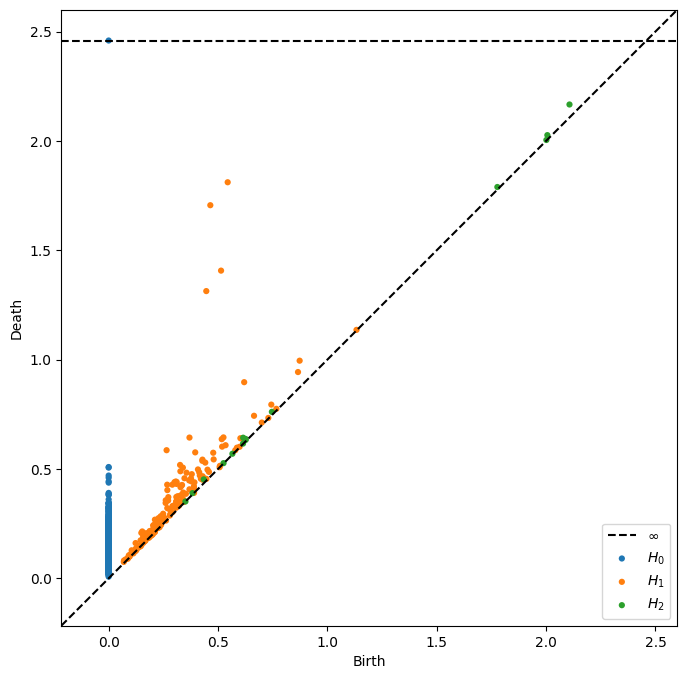

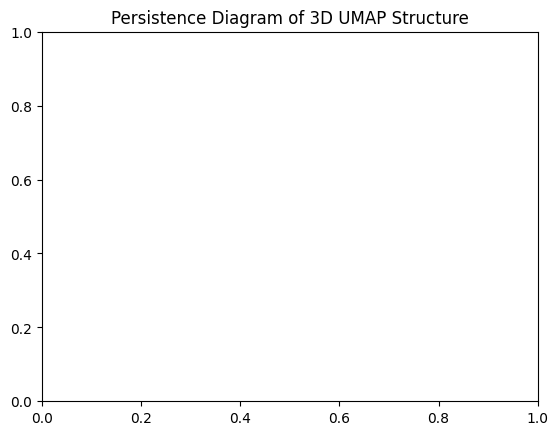

In [47]:
# --- 3D UMAP 위상 분석 (Topology Analysis of 3D UMAP) ---
# 눈으로 보이는 복잡한 구조(구멍, 빈 공간)가 수학적으로도 유의미한지 확인합니다.
# 3차원 데이터이므로 H2(Void, 텅 빈 공동)까지 분석할 수 있습니다.

print("Computing Persistent Homology on 3D UMAP embedding...")

# maxdim=2: H0(덩어리), H1(고리/터널), H2(공동/Void)
# 3D 공간의 점들이므로 계산이 매우 빠릅니다.
result_3d = ripser(embedding_3d, maxdim=2)
diagrams_3d = result_3d['dgms']

# 시각화
plt.figure(figsize=(10, 8))
plot_diagrams(diagrams_3d, show=True)
plt.title("Persistence Diagram of 3D UMAP Structure")
plt.show()

# --- 결과 해석 ---
# 1. H1 (주황색, Dimension 1): '고리'나 '터널' 구조입니다.
#    - 3D UMAP에서 보이는 '구멍'들이 여기에 해당합니다.
#    - 대각선에서 멀리 떨어진 점이 있다면, 그 구멍은 매우 뚜렷하고 중요한 특징입니다.
#
# 2. H2 (초록색, Dimension 2): '공동(Void)' 또는 '방(Room)' 같은 구조입니다.
#    - 데이터가 겉면(껍질)만 감싸고 있고, 속이 텅 빈 '축구공' 같은 형태일 때 나타납니다.
#    - 만약 H2 점이 뚜렷하다면, 신경 활동이 특정 '금지된 상태(Forbidden State)'를 중심으로
#      주변을 맴돌고 있다는 강력한 증거입니다.

In [48]:
# --- 3D 궤적 시각화 (Trajectory Line Plot) ---
# 프레임 순서대로 점들을 선으로 연결하여 뇌 활동이 어떻게 이동하는지 '경로'를 확인합니다.

import plotly.graph_objects as go

print("Generating 3D Trajectory Plot...")

# 1. 선 그래프 (Trajectory Path)
# 시간 순서대로 연결된 선을 그립니다.
line_trace = go.Scatter3d(
    x=df_umap_3d['UMAP1'],
    y=df_umap_3d['UMAP2'],
    z=df_umap_3d['UMAP3'],
    mode='lines',
    line=dict(color='gray', width=2, dash='solid'), # 회색 실선
    opacity=0.4,
    name='Trajectory Path'
)

# 2. 산점도 (Time Markers)
# 각 시점의 상태를 점으로 찍고, 색상으로 시간(Frame)을 표시합니다.
scatter_trace = go.Scatter3d(
    x=df_umap_3d['UMAP1'],
    y=df_umap_3d['UMAP2'],
    z=df_umap_3d['UMAP3'],
    mode='markers',
    marker=dict(
        size=3,
        color=df_umap_3d['Frame'],      # 색상: 시간(Frame)
        colorscale='Turbo',             # 무지개색 (보라->빨강)
        colorbar=dict(title='Frame'),
        opacity=0.8
    ),
    text=[f"Frame: {f}<br>Complexity: {c:.2f}" for f, c in zip(df_umap_3d['Frame'], df_umap_3d['Complexity'])],
    hoverinfo='text',
    name='Neural State'
)

# 3. 그래프 합치기 및 레이아웃 설정
fig_traj = go.Figure(data=[line_trace, scatter_trace])

fig_traj.update_layout(
    title='Neural State Trajectory in 3D UMAP Space (Connected by Time)',
    scene=dict(
        xaxis_title='UMAP1',
        yaxis_title='UMAP2',
        zaxis_title='UMAP3'
    ),
    width=900,
    height=700
)

fig_traj.show()

# --- 해석 팁 ---
# - 선을 따라가면 뇌 활동의 시간적 흐름을 볼 수 있습니다.
# - 선이 꼬이거나 원을 그리며 제자리로 돌아오는 구간(Loop)이 있는지 확인해보세요.
# - 선이 급격하게 점프하는 구간은 뇌 상태가 급변하는 시점입니다.

Generating 3D Trajectory Plot...


In [ ]:
# --- Cluster-wise 3D UMAP Analysis ---
# 각 클러스터 내부의 구조를 자세히 보기 위해, 클러스터별로 데이터를 나누어 다시 UMAP을 수행합니다.

import umap
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("Generating 3D UMAP for each cluster...")

# 클러스터 개수 확인 (위에서 n_clusters=5로 설정했다고 가정)
unique_labels = np.unique(cluster_labels)
n_clusters_found = len(unique_labels)

print(f"Found {n_clusters_found} clusters: {unique_labels}")

# 각 클러스터별 UMAP 수행 및 시각화
for label in unique_labels:
    # 해당 클러스터의 데이터만 추출
    mask = (cluster_labels == label)
    cluster_data = X_pca[mask]
    
    print(f"Cluster {label}: {cluster_data.shape[0]} frames")
    
    if cluster_data.shape[0] < 10:
        print(f"  -> Skipping Cluster {label} (too few points)")
        continue

    # UMAP (3D) 수행
    # n_neighbors를 데이터 크기에 맞춰 조절 (너무 크면 에러 발생 가능)
    n_neighbors = min(15, cluster_data.shape[0] - 1)
    reducer = umap.UMAP(n_components=3, n_neighbors=n_neighbors, min_dist=0.1, random_state=42)
    embedding = reducer.fit_transform(cluster_data)
    
    # 시각화
    fig = go.Figure(data=[go.Scatter3d(
        x=embedding[:, 0],
        y=embedding[:, 1],
        z=embedding[:, 2],
        mode='markers',
        marker=dict(
            size=3,
            color=embedding[:, 2], # Z축 값에 따라 색상 변화
            colorscale='Viridis',
            opacity=0.8
        )
    )])
    
    fig.update_layout(
        title=f"Cluster {label} Internal Structure (3D UMAP)",
        scene=dict(
            xaxis_title='UMAP 1',
            yaxis_title='UMAP 2',
            zaxis_title='UMAP 3'
        ),
        margin=dict(l=0, r=0, b=0, t=40),
        height=500
    )
    
    fig.show()
